In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support as score
from datetime import datetime

import seaborn as sns
sns.set(style="darkgrid")
#local
from tadat.pipeline import plots
from tadat.core import data, vectorizer, features, helpers, embeddings

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def ethnicity_multi_labels(x):
    if "ASIAN" in x:
        return "ASIAN"
    elif "AFRICAN" in x:
        return "BLACK"
    elif "HISPANIC" in x:
        return "HISPANIC"
    elif "WHITE" in x:
        return "WHITE"
    elif "NATIVE" in x:
        return "OTHER"
        return "NATIVE"
    else:
        return "OTHER"

def ethnicity_binary_labels(x):
    if "ASIAN" in x or "AFRICAN" in x or "HISPANIC" in x or "NATIVE" in x: 
        return "NON-WHITE"
    elif "WHITE" in x:
        return "WHITE"
    else:
        return "OTHER"

def get_ethnicity_dataset(df, path_out=None):
    df["ETHNICITY_LABEL"] = df["ETHNICITY"].apply(lambda x:ethnicity_binary_labels(x))
    df_ethnicity = df[["ETHNICITY_LABEL","TEXT"]]
    if path_out:
        df_ethnicity.to_csv(path_out,index=False, sep="\t", header=False)
        
    return df_ethnicity

def get_mortality_dataset(df, path_out=None):
    df["EXPIRE"] = df["HOSPITAL_EXPIRE_FLAG"]
    df_mortality = df[["EXPIRE","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"]]
    if path_out:
        df_mortality.to_csv(path_out,index=False, sep="\t", header=False)
    return df_mortality

def get_readmissions_dataset(mimic_path, patients_df, path_out=None):
    admissions_df = pd.read_csv(mimic_path+"ADMISSIONS.CSV.gz")
    data = []
    READMISSION_DELTA = float("inf")
    for _, patient in patients_df.iterrows():
        adm = admissions_df[admissions_df["SUBJECT_ID"] == patient["SUBJECT_ID"]]
        if len(adm) > 1:
            admission_times = list(adm.sort_values("ADMITTIME")["ADMITTIME"])
            for i in range(len(admission_times)-1):
                d1 = admission_times[i]
                d2 = admission_times[i+1]
                d1 = datetime.strptime(d1, "%Y-%m-%d %H:%M:%S")
                d2 = datetime.strptime(d2, "%Y-%m-%d %H:%M:%S")
                delta = d2 - d1
                if delta.days < READMISSION_DELTA:
                    data.append([1,patient["TEXT"],patient["GENDER"]])
                    break             
        else:
            data.append([0,patient["TEXT"],patient["GENDER"], 
                           patient["ETHNICITY_LABEL"], patient["ETHNICITY_BINARY"]])
    readm_df = pd.DataFrame(data, columns=["READMISSION","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
    if path_out:
        readm_df.to_csv(path_out,index=False, sep="\t", header=False)    
    return readm_df
    

def extract_patients(mimic_path, sample_size=None, path_out=None):
    all_notes = pd.read_csv(mimic_path+"NOTEEVENTS.CSV.gz")
    all_patients = pd.read_csv(mimic_path+"PATIENTS.CSV.gz")
    all_admissions = pd.read_csv(mimic_path+"ADMISSIONS.CSV.gz")
    #filter relevant columns
    notes = all_notes[["TEXT"]]
    notes["TEXT"] = notes["TEXT"].apply(lambda x: x.replace("\n","").replace("\t","").lower())
    patients = all_patients[["SUBJECT_ID","GENDER"]]
    admissions = all_admissions[["INSURANCE","ETHNICITY","HOSPITAL_EXPIRE_FLAG"]]
    #subsample?
    if sample_size:        
        patients = patients[:sample_size]
    #join dataframes
    patients = patients.join(admissions, how="inner", on="SUBJECT_ID",rsuffix="A_")
    patients = patients.join(notes, how="inner", on="SUBJECT_ID",rsuffix="N_")
    patients["ETHNICITY_LABEL"] = patients["ETHNICITY"].apply(lambda x:ethnicity_multi_labels(x))
    patients["ETHNICITY_BINARY"] = patients["ETHNICITY"].apply(lambda x:ethnicity_binary_labels(x))
    
    if path_out:
        patients.to_csv(path_out,index=False, sep="\t", header=False)    
    
    return patients

def subsample(df, label, ratio):
    RATIO = 1
    positive_size = df.groupby(label).size()[1]
    negative_size = int(positive_size * RATIO)
    all_size = positive_size + negative_size
    print("{} > Pos: {}/{} | Neg: {}/{}".format(label, positive_size, all_size,
                                                       negative_size,all_size))

    df_neg = df[df[label] == 0].head(negative_size)
    df_pos = df[df[label] == 1]
    df_all = df_neg.append(df_pos, ignore_index=True)
    return df_all

In [3]:
raw_data_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
out_data_path = "/Users/samir/Dev/projects/MIMIC/DATA/input/"

## Extract Data

In [4]:
# PATIENT_SAMPLE_SIZE = 10000
# mini_patients = extract_patients(raw_data_path, PATIENT_SAMPLE_SIZE,out_data_path+"mini_patients.csv")
# mini_patients
col_names = ["SUBJECT_ID","GENDER","INSURANCE","ETHNICITY","HOSPITAL_EXPIRE_FLAG","TEXT","ETHNICITY_LABEL","ETHNICITY_BINARY"]
mini_patients = pd.read_csv(out_data_path+"mini_patients.csv", header=None, 
                            sep="\t", names=col_names)
mini_patients

,SUBJECT_ID,GENDER,INSURANCE,ETHNICITY,HOSPITAL_EXPIRE_FLAG,TEXT,ETHNICITY_LABEL,ETHNICITY_BINARY
0,249,F,Medicaid,BLACK/AFRICAN AMERICAN,0,admission date: [**2149-6-2**] discharg...,BLACK,NON-WHITE
1,250,F,Medicare,UNKNOWN/NOT SPECIFIED,0,admission date: [**2149-9-2**] discharg...,OTHER,OTHER
2,251,M,Medicaid,BLACK/AFRICAN AMERICAN,0,admission date: [**2193-1-8**] d...,BLACK,NON-WHITE
3,252,M,Medicare,OTHER,0,admission date: [**2133-9-3**] d...,OTHER,OTHER
4,253,F,Private,HISPANIC OR LATINO,0,admission date: [**2103-8-16**] discharge...,HISPANIC,NON-WHITE
...,...,...,...,...,...,...,...,...
9995,11012,M,Private,WHITE,0,admission date: [**2154-2-7**] d...,WHITE,WHITE
9996,11013,F,Medicare,UNKNOWN/NOT SPECIFIED,0,admission date: [**2103-12-16**] ...,OTHER,OTHER
9997,11014,M,Medicare,UNKNOWN/NOT SPECIFIED,0,admission date: [**2104-2-4**] d...,OTHER,OTHER
9998,11015,M,Private,WHITE,0,admission date: [**2105-7-10**] ...,WHITE,WHITE


In [5]:
df_mortality = get_mortality_dataset(mini_patients, out_data_path+"mini_mortality.csv")
df_mortality

,EXPIRE,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,0,admission date: [**2149-6-2**] discharg...,F,BLACK,NON-WHITE
1,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
2,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
3,0,admission date: [**2133-9-3**] d...,M,OTHER,OTHER
4,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
...,...,...,...,...,...
9995,0,admission date: [**2154-2-7**] d...,M,WHITE,WHITE
9996,0,admission date: [**2103-12-16**] ...,F,OTHER,OTHER
9997,0,admission date: [**2104-2-4**] d...,M,OTHER,OTHER
9998,0,admission date: [**2105-7-10**] ...,M,WHITE,WHITE


In [6]:
mimic_path = "/Users/samir/Dev/resources/datasets/MIMIC/full/"
df_readm = get_readmissions_dataset(mimic_path, mini_patients, path_out=out_data_path+"/mini_readmissions.csv")
df_readm

,READMISSION,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,1,admission date: [**2149-6-2**] discharg...,F,None,None
1,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
2,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
3,1,admission date: [**2133-9-3**] d...,M,None,None
4,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
...,...,...,...,...,...
9995,0,admission date: [**2154-2-7**] d...,M,WHITE,WHITE
9996,0,admission date: [**2103-12-16**] ...,F,OTHER,OTHER
9997,0,admission date: [**2104-2-4**] d...,M,OTHER,OTHER
9998,0,admission date: [**2105-7-10**] ...,M,WHITE,WHITE


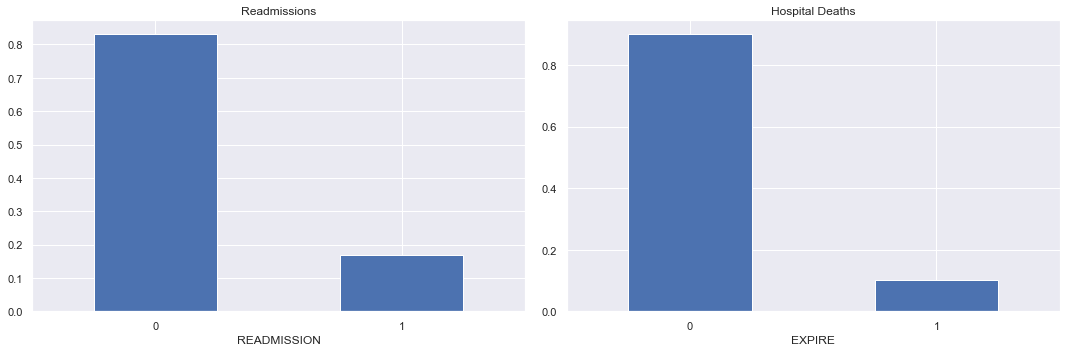

In [7]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
df_ag = df_readm.groupby("READMISSION").size()/df_readm.groupby("READMISSION").size().sum()
df_ag.plot(ax=ax[0],kind="bar", title="Readmissions", rot=0)

df_mg = df_mortality.groupby("EXPIRE").size()/df_mortality.groupby("EXPIRE").size().sum()
df_mg.plot(ax=ax[1],kind="bar", title="Hospital Deaths", rot=0)
plt.tight_layout()

In [8]:
#subsample majority class (negative)
df_readm_balanced = subsample(df_readm,"READMISSION",1)
df_mortality_balanced = subsample(df_mortality,"EXPIRE",1)
#save data
df_readm_balanced.to_csv(out_data_path+"/mini_readmissions_balanced.csv",index=False, sep="\t", header=False)
df_mortality_balanced.to_csv(out_data_path+"/mini_mortality_balanced.csv",index=False, sep="\t", header=False)



READMISSION > Pos: 1696/3392 | Neg: 1696/3392
EXPIRE > Pos: 1001/2002 | Neg: 1001/2002


## Read Data

In [10]:
df_mortality = pd.read_csv(out_data_path+"mini_mortality_balanced.csv",sep="\t", header=None, names=["EXPIRE","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
df_mortality 

,EXPIRE,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,0,admission date: [**2149-6-2**] discharg...,F,BLACK,NON-WHITE
1,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
2,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
3,0,admission date: [**2133-9-3**] d...,M,OTHER,OTHER
4,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
...,...,...,...,...,...
1997,1,admission date: [**2190-5-22**] ...,M,OTHER,OTHER
1998,1,admission date: [**2118-7-29**] ...,F,OTHER,OTHER
1999,1,admission date: [**2114-5-24**] dischar...,F,WHITE,WHITE
2000,1,admission date: [**2152-9-22**] ...,F,OTHER,OTHER


In [11]:
df_mortality.groupby("ETHNICITY_LABEL").size()

ETHNICITY_LABEL
ASIAN         64
BLACK        201
HISPANIC      49
OTHER        356
WHITE       1332
dtype: int64

In [12]:
df_mortality.groupby("ETHNICITY_BINARY").size()

ETHNICITY_BINARY
NON-WHITE     315
OTHER         355
WHITE        1332
dtype: int64

In [13]:
df_readmission = pd.read_csv(out_data_path+"mini_readmissions_balanced.csv",sep="\t", header=None, names=["READMISSION","TEXT","GENDER","ETHNICITY_LABEL","ETHNICITY_BINARY"])
df_readmission

,READMISSION,TEXT,GENDER,ETHNICITY_LABEL,ETHNICITY_BINARY
0,0,admission date: [**2149-9-2**] discharg...,F,OTHER,OTHER
1,0,admission date: [**2193-1-8**] d...,M,BLACK,NON-WHITE
2,0,admission date: [**2103-8-16**] discharge...,F,HISPANIC,NON-WHITE
3,0,admission date: [**2196-4-27**] discharge...,M,OTHER,OTHER
4,0,admission date: [**2158-1-5**] d...,F,OTHER,OTHER
...,...,...,...,...,...
3387,1,admission date: [**2175-6-2**] discharge ...,M,NaN,NaN
3388,1,admission date: [**2148-4-4**] d...,F,NaN,NaN
3389,1,admission date: [**2135-4-10**] ...,F,NaN,NaN
3390,1,admission date: [**2183-5-9**] d...,M,NaN,NaN


In [14]:
df_readmission.groupby("ETHNICITY_LABEL").size()

ETHNICITY_LABEL
ASIAN         67
BLACK        164
HISPANIC      59
OTHER        267
WHITE       1139
dtype: int64

In [15]:
df_readmission.groupby("ETHNICITY_BINARY").size()

ETHNICITY_BINARY
NON-WHITE     292
OTHER         265
WHITE        1139
dtype: int64

## Analytics

In [73]:
def vectorize_data(train_split, test_split_M, test_split_F):
    #vectorize instances
    train_X = data.getX(train_split)
    test_X_M = data.getX(test_split_M)
    test_X_F = data.getX(test_split_F)
    
    train_X, word_vocab = vectorizer.docs2idx(train_X)
    test_X_M,_ = vectorizer.docs2idx(test_X_M, word_vocab)
    test_X_F,_ = vectorizer.docs2idx(test_X_F, word_vocab)
    #vectorize labels
    train_Y = data.getY(train_split)
    test_Y_M = data.getY(test_split_M) 
    test_Y_F = data.getY(test_split_F)    
    label_vocab = vectorizer.get_labels_vocab(train_Y+test_Y_M+test_Y_F)
    train_Y,_ = vectorizer.label2idx(train_Y, label_vocab)
    test_Y_M,_ = vectorizer.label2idx(test_Y_M, label_vocab)
    test_Y_F,_ = vectorizer.label2idx(test_Y_F, label_vocab)
    
    return train_X, train_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab

def get_features(data, vocab_size, feature_type, word_vectors=None):
    if feature_type == "BOW-bin":
        X = features.BOW(data, vocab_size,sparse=True)
    elif feature_type == "BOW-freq":
        X = features.BOW_freq(data, vocab_size,sparse=True)
    elif feature_type == "BOE-bin":
        X = features.BOE(data, word_vectors,"bin")
    elif feature_type == "BOE-sum": 
        X = features.BOE(data, word_vectors,"sum")
    else:
        raise NotImplementedError
    return X
    

def evaluate_classifier(X_train, Y_train, X_test, Y_test,
                   labels, model_name, random_seed=1234, res_path=None):
    model = SGDClassifier(random_state=random_seed)
    model.fit(X_train,Y_train)
    Y_hat = model.predict(X_test)
    microF1 = f1_score(Y_test, Y_hat, average="micro") 
    macroF1 = f1_score(Y_test, Y_hat, average="macro") 
    acc = accuracy_score(Y_test, Y_hat)
    precision, recall, fscore, support = score(Y_test, Y_hat)

    res = {"model":model_name, \
            "seed":random_seed, \
            "acc":round(acc,3), \
            "microF1":round(microF1,3), \
            "macroF1":round(macroF1,3)
            }

    for l, i in labels.items():
        try:
            fs = round(fscore[i],3)
        except IndexError:
            fs = 0
        res["{}-f1".format(l)] = fs
#     helpers.print_results(res)
    if res_path is not None:
        cols = ["dataset", "model", "acc", "avgF1"]
        # helpers.save_results(res, res_path, sep="\t", columns=cols)
        helpers.save_results(res, res_path, sep="\t")
    return res

def get_deltas(results_M, results_F):
    #resuts
    df_M = pd.DataFrame(results_M)
    df_F = pd.DataFrame(results_F)
#     from pdb import set_trace; set_trace()
    #compute deltas
    df_delta = df_M.sub(df_F.iloc[:,2:])
    df_delta["model"] = df_M["model"]
    df_delta["seed"] = df_M["seed"]   
    
    #transform results into "long format"
    df_delta_long = df_delta.melt(id_vars=["seed","model"], value_vars=["microF1","macroF1","0-f1","1-f1"], 
                                        var_name="metric", value_name="delta")
    return df_delta, df_delta_long

def run(df, x_label, y_label, feature_type, target_label, target_value, split=0.8):
    #split into training and test sets
    train_split, test_split = data.shuffle_split_idx(df[y_label], split)
    df_train = df.iloc[train_split,:]
    df_test = df.iloc[test_split,:]
    df_test_M = df_test[df_test[target_label] == target_value]
    df_test_F = df_test[df_test[target_label] != target_value]
    
    print("M: {} | F: {}".format(len(df_test_M),len(df_test_F)))
    #transform the data into the right format
    train = data.read_dataframe(df_train, x_label, y_label)
    test_M = data.read_dataframe(df_test_M, x_label, y_label)
    test_F = data.read_dataframe(df_test_F, x_label, y_label)
    
    #get vectorized train/test data 
    train_X, train_Y, test_X_M, test_Y_M, test_X_F, test_Y_F, word_vocab, label_vocab = vectorize_data(train, test_M, test_F)
    #extract features
    train_feats = get_features(train_X, len(word_vocab), feature_type)
    test_feats_M = get_features(test_X_M, len(word_vocab), feature_type)
    test_feats_F = get_features(test_X_F, len(word_vocab), feature_type)

    #train/test classifier for each random seed
    random_seeds = list(range(20))
    results_m = []
    results_f = []
    for r in random_seeds:
        print("[running seed: {}]".format(r))
        res_m = evaluate_classifier(train_feats, train_Y, test_feats_M, test_Y_M, label_vocab, feature_type, r)
        results_m.append(res_m)
        res_f = evaluate_classifier(train_feats, train_Y, test_feats_F, test_Y_F, label_vocab, feature_type, r)
        results_f.append(res_f)
    return results_m, results_f

def outcome_anaylsis(df, x_label, y_label, title, LIM=0.5):
    results_BOW_M_W, results_BOW_F_W = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "WHITE", split=0.8)
    results_BOW_M_N, results_BOW_F_N = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "BLACK", split=0.8)
    results_BOW_M_A, results_BOW_F_A = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "ASIAN", split=0.8)
    results_BOW_M_H, results_BOW_F_H = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "HISPANIC", split=0.8)

    results_BOW_freq_M_W, results_BOW_freq_F_W = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "WHITE", split=0.8)
    results_BOW_freq_M_N, results_BOW_freq_F_N = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "BLACK", split=0.8)
    results_BOW_freq_M_A, results_BOW_freq_F_A = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "ASIAN", split=0.8)
    results_BOW_freq_M_H, results_BOW_freq_F_H = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "HISPANIC", split=0.8)
    
    #results
    df_bb_delta_W, df_bb_delta_long_W = get_deltas(results_BOW_M_W,results_BOW_F_W)
    df_bb_delta_N, df_bb_delta_long_N = get_deltas(results_BOW_M_N,results_BOW_F_N)
    df_bb_delta_A, df_bb_delta_long_A = get_deltas(results_BOW_M_A,results_BOW_F_A)
    df_bb_delta_H, df_bb_delta_long_H = get_deltas(results_BOW_M_H,results_BOW_F_H)

    df_bf_delta_W, df_bf_delta_long_W = get_deltas(results_BOW_freq_M_W,results_BOW_freq_F_W)
    df_bf_delta_N, df_bf_delta_long_N = get_deltas(results_BOW_freq_M_N,results_BOW_freq_F_N)
    df_bf_delta_A, df_bf_delta_long_A = get_deltas(results_BOW_freq_M_A,results_BOW_freq_F_A)
    df_bf_delta_H, df_bf_delta_long_H = get_deltas(results_BOW_freq_M_H,results_BOW_freq_F_H)
    
    #plots
    fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,9))

    plots.plot_df(df=df_bb_delta_W,ax=ax[0][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df_bb_delta_N,ax=ax[0][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df_bb_delta_A,ax=ax[0][2],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df_bb_delta_H,ax=ax[0][3],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)

    plots.plot_df(df=df_bf_delta_W,ax=ax[1][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df_bf_delta_N,ax=ax[1][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df_bf_delta_A,ax=ax[1][2],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
    plots.plot_df(df=df_bf_delta_H,ax=ax[1][3],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)

    ax[0][0].set_title("bow-bin Delta White v Others")
    ax[0][1].set_title("bow-bin Delta Black v Others")
    ax[0][2].set_title("bow-bin Delta Asian v Others")
    ax[0][3].set_title("bow-bin Delta Hispanic v Others")

    ax[1][0].set_title("bow-freq Delta White v Others")
    ax[1][1].set_title("bow-freq Delta Black v Others")
    ax[1][2].set_title("bow-freq Delta Asian v Others")
    ax[1][3].set_title("bow-freq Delta Hispanic v Others")

    ax[0][0].legend(loc='best')
    ax[0][1].legend(loc='best')
    ax[0][2].legend(loc='best')
    ax[0][3].legend(loc='best')
    ax[1][0].legend(loc='best')
    ax[1][1].legend(loc='best')
    ax[1][2].legend(loc='best')
    ax[1][3].legend(loc='best')

    fig.suptitle(title ,y=1.01)
    
    df_delta_long_W = df_bb_delta_long_W.append(df_bf_delta_long_W)
    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_W, col="model")
    ax1, ax2 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    ax1.set_ylim([-LIM,LIM])
    ax2.set_ylim([-LIM,LIM])
    plt.suptitle("Whites vs Others")
    plt.show()
    
    df_delta_long_N = df_bb_delta_long_N.append(df_bf_delta_long_N)
    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_N, col="model")
    ax1, ax2 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    ax1.set_ylim([-LIM,LIM])
    ax2.set_ylim([-LIM,LIM])
    plt.suptitle("Blacks vs Others")
    
    df_delta_long_A = df_bb_delta_long_A.append(df_bf_delta_long_A)
    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_A, col="model")
    ax1, ax2 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    ax1.set_ylim([-LIM,LIM])
    ax2.set_ylim([-LIM,LIM])
    plt.suptitle("Asians vs Others")
    
    df_delta_long_H = df_bb_delta_long_H.append(df_bf_delta_long_H)
    g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_H, col="model")
    ax1, ax2 = g.axes[0]
    ax1.axhline(0, ls='--',c="r")
    ax2.axhline(0, ls='--',c="r")
    ax1.set_ylim([-LIM,LIM])
    ax2.set_ylim([-LIM,LIM])
    plt.suptitle("Hispanics vs Others")
    plt.tight_layout()
    plt.show()

## Mortality

M: 279 | F: 123


/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]
M: 23 | F: 379
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]
M: 14 | F: 388
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[runnin

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]
M: 23 | F: 379
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

[running seed: 18]
[running seed: 19]
M: 14 | F: 388
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]
[running seed: 5]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]
[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]
[running seed: 15]
[running seed: 16]
[running seed: 17]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

[running seed: 18]
[running seed: 19]
M: 12 | F: 390
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]
[running seed: 3]
[running seed: 4]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

[running seed: 5]
[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

[running seed: 10]
[running seed: 11]
[running seed: 12]
[running seed: 13]
[running seed: 14]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

[running seed: 15]
[running seed: 16]
[running seed: 17]
[running seed: 18]
[running seed: 19]


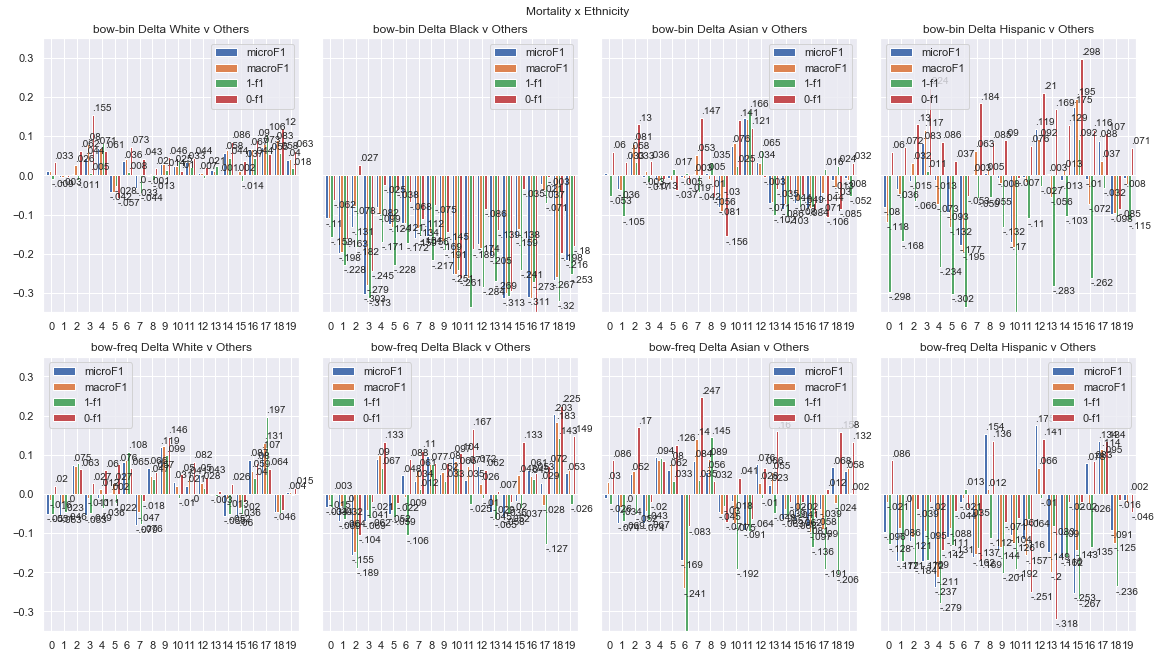

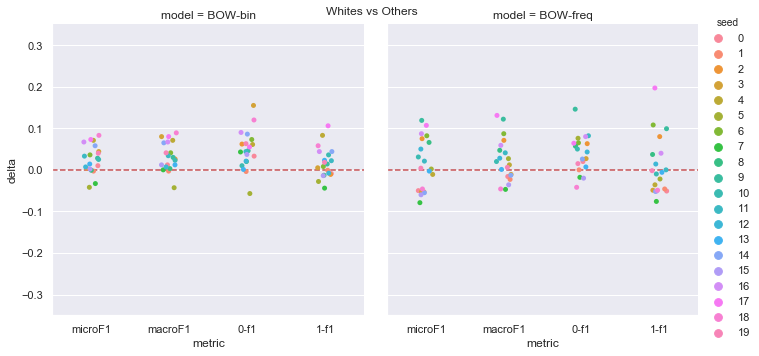

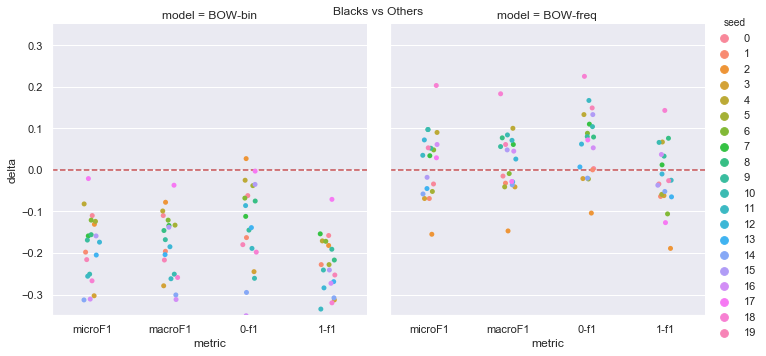

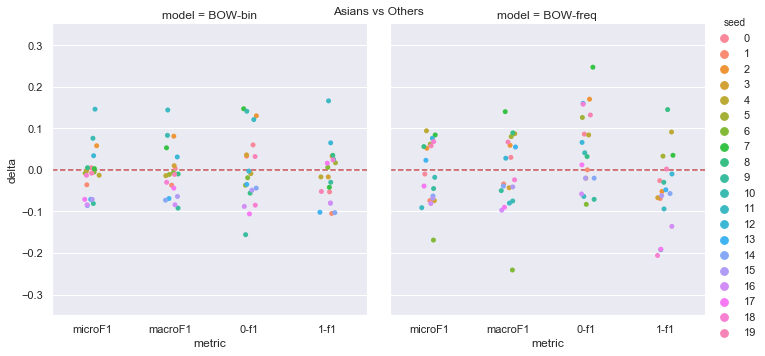

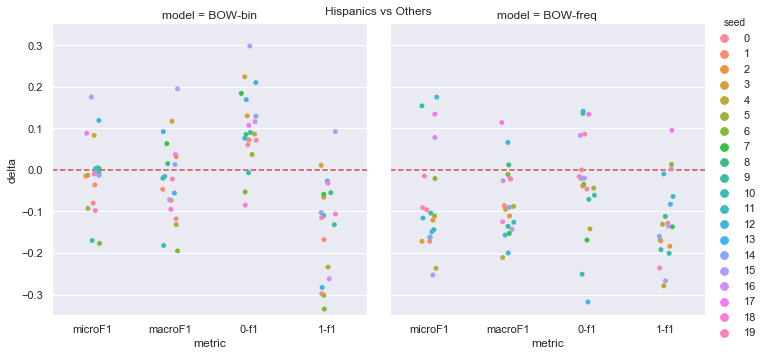

In [74]:
outcome_anaylsis(df_mortality,"TEXT","EXPIRE","Mortality x Ethnicity",0.35)

In [ ]:
df = df_readmission
x_label = "TEXT"
y_label = "READMISSION"


outcome_anaylsis(df_readmission,"TEXT","READMISSION","Readmission x Ethnicity",0.75)

M: 245 | F: 435


/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
[running seed: 1]
[running seed: 2]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6

[running seed: 3]
[running seed: 4]
[running seed: 5]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

[running seed: 6]
[running seed: 7]
[running seed: 8]
[running seed: 9]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

[running seed: 10]
[running seed: 11]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[running seed: 12]
[running seed: 13]
[running seed: 14]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

[running seed: 15]
[running seed: 16]
[running seed: 17]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

[running seed: 18]
[running seed: 19]
M: 22 | F: 658


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

[running seed: 1]
[running seed: 2]
[running seed: 3]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

[running seed: 4]
[running seed: 5]
[running seed: 6]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

[running seed: 7]
[running seed: 8]
[running seed: 9]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

[running seed: 10]
[running seed: 11]
[running seed: 12]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[running seed: 13]
[running seed: 14]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


[running seed: 15]
[running seed: 16]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

[running seed: 17]
[running seed: 18]
[running seed: 19]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


M: 7 | F: 673


In [17]:
df = df_mortality
x_label = "TEXT"
y_label = "EXPIRE"

results_BOW_M_W, results_BOW_F_W = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "WHITE", split=0.8)
results_BOW_M_N, results_BOW_F_N = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "BLACK", split=0.8)
results_BOW_M_A, results_BOW_F_A = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "ASIAN", split=0.8)
results_BOW_M_H, results_BOW_F_H = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "HISPANIC", split=0.8)

results_BOW_freq_M_W, results_BOW_freq_F_W = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "WHITE", split=0.8)
results_BOW_freq_M_N, results_BOW_freq_F_N = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "BLACK", split=0.8)
results_BOW_freq_M_A, results_BOW_freq_F_A = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "ASIAN", split=0.8)
results_BOW_freq_M_H, results_BOW_freq_F_H = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "HISPANIC", split=0.8)


M: 279 | F: 123


/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-bin| seed: 0| acc: 0.498| microF1: 0.498| macroF1: 0.498| 0-f1: 0.485| 1-f1: 0.51| 
** model: BOW-bin| seed: 0| acc: 0.488| microF1: 0.488| macroF1: 0.486| 0-f1: 0.452| 1-f1: 0.519| 
[running seed: 1]
** model: BOW-bin| seed: 1| acc: 0.534| microF1: 0.534| macroF1: 0.532| 0-f1: 0.5| 1-f1: 0.564| 
** model: BOW-bin| seed: 1| acc: 0.537| microF1: 0.537| macroF1: 0.535| 0-f1: 0.504| 1-f1: 0.565| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.516| microF1: 0.516| macroF1: 0.463| 0-f1: 0.293| 1-f1: 0.632| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


** model: BOW-bin| seed: 2| acc: 0.512| microF1: 0.512| macroF1: 0.437| 0-f1: 0.231| 1-f1: 0.643| 
[running seed: 3]
** model: BOW-bin| seed: 3| acc: 0.516| microF1: 0.516| macroF1: 0.489| 0-f1: 0.372| 1-f1: 0.606| 
** model: BOW-bin| seed: 3| acc: 0.472| microF1: 0.472| macroF1: 0.409| 0-f1: 0.217| 1-f1: 0.601| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.534| microF1: 0.534| macroF1: 0.532| 0-f1: 0.561| 1-f1: 0.504| 
** model: BOW-bin| seed: 4| acc: 0.463| microF1: 0.463| macroF1: 0.461| 0-f1: 0.5| 1-f1: 0.421| 
[running seed: 5]
** model: BOW-bin| seed: 5| acc: 0.495| microF1: 0.495| macroF1: 0.494| 0-f1: 0.48| 1-f1: 0.509| 
** model: BOW-bin| seed: 5| acc: 0.537| microF1: 0.537| macroF1: 0.537| 0-f1: 0.537| 1-f1: 0.537| 
[running seed: 6]
** model: BOW-bin| seed: 6| acc: 0.516| microF1: 0.516| macroF1: 0.516| 0-f1: 0.502| 1-f1: 0.53| 
** model: BOW-bin| seed: 6| acc: 0.48| microF1: 0.48| macroF1: 0.475| 0-f1: 0.429| 1-f1: 0.522| 
[running seed: 7]
** model: BOW-bin| seed: 

** model: BOW-bin| seed: 6| acc: 0.5| microF1: 0.5| macroF1: 0.497| 0-f1: 0.462| 1-f1: 0.533| 
** model: BOW-bin| seed: 6| acc: 0.505| microF1: 0.505| macroF1: 0.504| 0-f1: 0.481| 1-f1: 0.527| 
[running seed: 7]
** model: BOW-bin| seed: 7| acc: 0.5| microF1: 0.5| macroF1: 0.476| 0-f1: 0.364| 1-f1: 0.588| 
** model: BOW-bin| seed: 7| acc: 0.497| microF1: 0.497| macroF1: 0.423| 0-f1: 0.217| 1-f1: 0.63| 
[running seed: 8]
** model: BOW-bin| seed: 8| acc: 0.5| microF1: 0.5| macroF1: 0.476| 0-f1: 0.364| 1-f1: 0.588| 
** model: BOW-bin| seed: 8| acc: 0.495| microF1: 0.495| macroF1: 0.486| 0-f1: 0.42| 1-f1: 0.553| 
[running seed: 9]
** model: BOW-bin| seed: 9| acc: 0.429| microF1: 0.429| macroF1: 0.417| 0-f1: 0.333| 1-f1: 0.5| 
** model: BOW-bin| seed: 9| acc: 0.51| microF1: 0.51| macroF1: 0.509| 0-f1: 0.489| 1-f1: 0.53| 
[running seed: 10]
** model: BOW-bin| seed: 10| acc: 0.571| microF1: 0.571| macroF1: 0.571| 0-f1: 0.571| 1-f1: 0.571| 
** model: BOW-bin| seed: 10| acc: 0.495| microF1: 0.49

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 5| acc: 0.439| microF1: 0.439| macroF1: 0.38| 0-f1: 0.188| 1-f1: 0.571| 
[running seed: 6]
** model: BOW-freq| seed: 6| acc: 0.545| microF1: 0.545| macroF1: 0.523| 0-f1: 0.625| 1-f1: 0.42| 
** model: BOW-freq| seed: 6| acc: 0.463| microF1: 0.463| macroF1: 0.436| 0-f1: 0.56| 1-f1: 0.312| 
[running seed: 7]
** model: BOW-freq| seed: 7| acc: 0.466| microF1: 0.466| macroF1: 0.384| 0-f1: 0.158| 1-f1: 0.609| 
** model: BOW-freq| seed: 7| acc: 0.545| microF1: 0.545| macroF1: 0.431| 0-f1: 0.176| 1-f1: 0.685| 
[running seed: 8]
** model: BOW-freq| seed: 8| acc: 0.538| microF1: 0.538| macroF1: 0.404| 0-f1: 0.686| 1-f1: 0.122| 
** model: BOW-freq| seed: 8| acc: 0.472| microF1: 0.472| macroF1: 0.357| 0-f1: 0.629| 1-f1: 0.085| 
[running seed: 9]
** model: BOW-freq| seed: 9| acc: 0.509| microF1: 0.509| macroF1: 0.502| 0-f1: 0.445| 1-f1: 0.559| 
** model: BOW-freq| seed: 9| acc: 0.39| microF1: 0.39| macroF1: 0.38| 0-f1: 0.299| 1-f1: 0.46| 
[running seed: 10]
** model: BOW-fr

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


** model: BOW-freq| seed: 15| acc: 0.477| microF1: 0.477| macroF1: 0.329| 0-f1: 0.014| 1-f1: 0.644| 
** model: BOW-freq| seed: 15| acc: 0.537| microF1: 0.537| macroF1: 0.365| 0-f1: 0.034| 1-f1: 0.695| 
[running seed: 16]
** model: BOW-freq| seed: 16| acc: 0.534| microF1: 0.534| macroF1: 0.412| 0-f1: 0.68| 1-f1: 0.145| 
** model: BOW-freq| seed: 16| acc: 0.447| microF1: 0.447| macroF1: 0.353| 0-f1: 0.6| 1-f1: 0.105| 
[running seed: 17]
** model: BOW-freq| seed: 17| acc: 0.57| microF1: 0.57| macroF1: 0.553| 0-f1: 0.641| 1-f1: 0.464| 
** model: BOW-freq| seed: 17| acc: 0.463| microF1: 0.463| macroF1: 0.422| 0-f1: 0.577| 1-f1: 0.267| 
[running seed: 18]
** model: BOW-freq| seed: 18| acc: 0.491| microF1: 0.491| macroF1: 0.486| 0-f1: 0.536| 1-f1: 0.437| 
** model: BOW-freq| seed: 18| acc: 0.537| microF1: 0.537| macroF1: 0.532| 0-f1: 0.578| 1-f1: 0.486| 
[running seed: 19]
** model: BOW-freq| seed: 19| acc: 0.516| microF1: 0.516| macroF1: 0.509| 0-f1: 0.449| 1-f1: 0.569| 
** model: BOW-freq| 

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 5| acc: 0.391| microF1: 0.391| macroF1: 0.361| 0-f1: 0.222| 1-f1: 0.5| 
** model: BOW-freq| seed: 5| acc: 0.443| microF1: 0.443| macroF1: 0.402| 0-f1: 0.244| 1-f1: 0.559| 
[running seed: 6]
** model: BOW-freq| seed: 6| acc: 0.565| microF1: 0.565| macroF1: 0.487| 0-f1: 0.688| 1-f1: 0.286| 
** model: BOW-freq| seed: 6| acc: 0.517| microF1: 0.517| macroF1: 0.496| 0-f1: 0.6| 1-f1: 0.392| 
[running seed: 7]
** model: BOW-freq| seed: 7| acc: 0.522| microF1: 0.522| macroF1: 0.456| 0-f1: 0.267| 1-f1: 0.645| 
** model: BOW-freq| seed: 7| acc: 0.488| microF1: 0.488| macroF1: 0.395| 0-f1: 0.157| 1-f1: 0.633| 
[running seed: 8]
** model: BOW-freq| seed: 8| acc: 0.609| microF1: 0.609| macroF1: 0.462| 0-f1: 0.743| 1-f1: 0.182| 
** model: BOW-freq| seed: 8| acc: 0.512| microF1: 0.512| macroF1: 0.385| 0-f1: 0.664| 1-f1: 0.106| 
[running seed: 9]
** model: BOW-freq| seed: 9| acc: 0.522| microF1: 0.522| macroF1: 0.518| 0-f1: 0.476| 1-f1: 0.56| 
** model: BOW-freq| seed: 9| acc:

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 16| acc: 0.504| microF1: 0.504| macroF1: 0.391| 0-f1: 0.653| 1-f1: 0.13| 
[running seed: 17]
** model: BOW-freq| seed: 17| acc: 0.565| microF1: 0.565| macroF1: 0.487| 0-f1: 0.688| 1-f1: 0.286| 
** model: BOW-freq| seed: 17| acc: 0.536| microF1: 0.536| macroF1: 0.515| 0-f1: 0.616| 1-f1: 0.413| 
[running seed: 18]
** model: BOW-freq| seed: 18| acc: 0.696| microF1: 0.696| macroF1: 0.673| 0-f1: 0.759| 1-f1: 0.588| 
** model: BOW-freq| seed: 18| acc: 0.493| microF1: 0.493| macroF1: 0.49| 0-f1: 0.534| 1-f1: 0.445| 
[running seed: 19]
** model: BOW-freq| seed: 19| acc: 0.565| microF1: 0.565| macroF1: 0.564| 0-f1: 0.583| 1-f1: 0.545| 
** model: BOW-freq| seed: 19| acc: 0.512| microF1: 0.512| macroF1: 0.503| 0-f1: 0.434| 1-f1: 0.571| 
M: 14 | F: 388
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-freq| seed: 0| acc: 0.5| microF1: 0.5| macroF1: 0.427| 0-f1: 0.222| 1-f1: 0.632| 
** model: BOW-freq| seed: 0| acc: 0.51| microF1: 0.51| macroF1: 0.397|

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 5| acc: 0.5| microF1: 0.5| macroF1: 0.476| 0-f1: 0.364| 1-f1: 0.588| 
** model: BOW-freq| seed: 5| acc: 0.438| microF1: 0.438| macroF1: 0.396| 0-f1: 0.238| 1-f1: 0.555| 
[running seed: 6]
** model: BOW-freq| seed: 6| acc: 0.357| microF1: 0.357| macroF1: 0.263| 0-f1: 0.526| 1-f1: 0.0| 
** model: BOW-freq| seed: 6| acc: 0.526| microF1: 0.526| macroF1: 0.504| 0-f1: 0.609| 1-f1: 0.399| 
[running seed: 7]
** model: BOW-freq| seed: 7| acc: 0.571| microF1: 0.571| macroF1: 0.533| 0-f1: 0.4| 1-f1: 0.667| 
** model: BOW-freq| seed: 7| acc: 0.487| microF1: 0.487| macroF1: 0.393| 0-f1: 0.153| 1-f1: 0.632| 
[running seed: 8]
** model: BOW-freq| seed: 8| acc: 0.571| microF1: 0.571| macroF1: 0.475| 0-f1: 0.7| 1-f1: 0.25| 
** model: BOW-freq| seed: 8| acc: 0.515| microF1: 0.515| macroF1: 0.386| 0-f1: 0.668| 1-f1: 0.105| 
[running seed: 9]
** model: BOW-freq| seed: 9| acc: 0.429| microF1: 0.429| macroF1: 0.417| 0-f1: 0.333| 1-f1: 0.5| 
** model: BOW-freq| seed: 9| acc: 0.474| 

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 16| acc: 0.51| microF1: 0.51| macroF1: 0.397| 0-f1: 0.658| 1-f1: 0.136| 
[running seed: 17]
** model: BOW-freq| seed: 17| acc: 0.5| microF1: 0.5| macroF1: 0.427| 0-f1: 0.632| 1-f1: 0.222| 
** model: BOW-freq| seed: 17| acc: 0.539| microF1: 0.539| macroF1: 0.517| 0-f1: 0.62| 1-f1: 0.413| 
[running seed: 18]
** model: BOW-freq| seed: 18| acc: 0.571| microF1: 0.571| macroF1: 0.475| 0-f1: 0.7| 1-f1: 0.25| 
** model: BOW-freq| seed: 18| acc: 0.503| microF1: 0.503| macroF1: 0.499| 0-f1: 0.542| 1-f1: 0.456| 
[running seed: 19]
** model: BOW-freq| seed: 19| acc: 0.571| microF1: 0.571| macroF1: 0.571| 0-f1: 0.571| 1-f1: 0.571| 
** model: BOW-freq| seed: 19| acc: 0.513| microF1: 0.513| macroF1: 0.504| 0-f1: 0.439| 1-f1: 0.569| 
M: 12 | F: 390
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-freq| seed: 0| acc: 0.417| microF1: 0.417| macroF1: 0.378| 0-f1: 0.222| 1-f1: 0.533| 
** model: BOW-freq| seed: 0| acc: 0.513| microF1: 0.513| macroF1: 0.399| 0

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 5| acc: 0.333| microF1: 0.333| macroF1: 0.314| 0-f1: 0.2| 1-f1: 0.429| 
** model: BOW-freq| seed: 5| acc: 0.444| microF1: 0.444| macroF1: 0.402| 0-f1: 0.244| 1-f1: 0.56| 
[running seed: 6]
** model: BOW-freq| seed: 6| acc: 0.5| microF1: 0.5| macroF1: 0.486| 0-f1: 0.571| 1-f1: 0.4| 
** model: BOW-freq| seed: 6| acc: 0.521| microF1: 0.521| macroF1: 0.497| 0-f1: 0.606| 1-f1: 0.387| 
[running seed: 7]
** model: BOW-freq| seed: 7| acc: 0.333| microF1: 0.333| macroF1: 0.25| 0-f1: 0.0| 1-f1: 0.5| 
** model: BOW-freq| seed: 7| acc: 0.495| microF1: 0.495| macroF1: 0.403| 0-f1: 0.169| 1-f1: 0.637| 
[running seed: 8]
** model: BOW-freq| seed: 8| acc: 0.667| microF1: 0.667| macroF1: 0.4| 0-f1: 0.8| 1-f1: 0.0| 
** model: BOW-freq| seed: 8| acc: 0.513| microF1: 0.513| macroF1: 0.388| 0-f1: 0.664| 1-f1: 0.112| 
[running seed: 9]
** model: BOW-freq| seed: 9| acc: 0.333| microF1: 0.333| macroF1: 0.333| 0-f1: 0.333| 1-f1: 0.333| 
** model: BOW-freq| seed: 9| acc: 0.477| microF1

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 10| acc: 0.521| microF1: 0.521| macroF1: 0.504| 0-f1: 0.594| 1-f1: 0.414| 
[running seed: 11]
** model: BOW-freq| seed: 11| acc: 0.333| microF1: 0.333| macroF1: 0.25| 0-f1: 0.0| 1-f1: 0.5| 
** model: BOW-freq| seed: 11| acc: 0.449| microF1: 0.449| macroF1: 0.407| 0-f1: 0.251| 1-f1: 0.564| 
[running seed: 12]
** model: BOW-freq| seed: 12| acc: 0.667| microF1: 0.667| macroF1: 0.4| 0-f1: 0.8| 1-f1: 0.0| 
** model: BOW-freq| seed: 12| acc: 0.492| microF1: 0.492| macroF1: 0.334| 0-f1: 0.659| 1-f1: 0.01| 
[running seed: 13]
** model: BOW-freq| seed: 13| acc: 0.333| microF1: 0.333| macroF1: 0.25| 0-f1: 0.0| 1-f1: 0.5| 
** model: BOW-freq| seed: 13| acc: 0.482| microF1: 0.482| macroF1: 0.45| 0-f1: 0.318| 1-f1: 0.583| 
[running seed: 14]
** model: BOW-freq| seed: 14| acc: 0.333| microF1: 0.333| macroF1: 0.25| 0-f1: 0.0| 1-f1: 0.5| 
** model: BOW-freq| seed: 14| acc: 0.495| microF1: 0.495| macroF1: 0.34| 0-f1: 0.02| 1-f1: 0.66| 
[running seed: 15]
** model: BOW-freq| se

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for

** model: BOW-freq| seed: 16| acc: 0.583| microF1: 0.583| macroF1: 0.368| 0-f1: 0.737| 1-f1: 0.0| 
** model: BOW-freq| seed: 16| acc: 0.505| microF1: 0.505| macroF1: 0.394| 0-f1: 0.654| 1-f1: 0.135| 
[running seed: 17]
** model: BOW-freq| seed: 17| acc: 0.667| microF1: 0.667| macroF1: 0.625| 0-f1: 0.75| 1-f1: 0.5| 
** model: BOW-freq| seed: 17| acc: 0.533| microF1: 0.533| macroF1: 0.511| 0-f1: 0.616| 1-f1: 0.405| 
[running seed: 18]
** model: BOW-freq| seed: 18| acc: 0.417| microF1: 0.417| macroF1: 0.378| 0-f1: 0.533| 1-f1: 0.222| 
** model: BOW-freq| seed: 18| acc: 0.508| microF1: 0.508| macroF1: 0.503| 0-f1: 0.549| 1-f1: 0.458| 
[running seed: 19]
** model: BOW-freq| seed: 19| acc: 0.5| microF1: 0.5| macroF1: 0.486| 0-f1: 0.4| 1-f1: 0.571| 
** model: BOW-freq| seed: 19| acc: 0.515| microF1: 0.515| macroF1: 0.508| 0-f1: 0.446| 1-f1: 0.569| 


## Results

In [32]:
#results
df_bb_delta_W, df_bb_delta_long_W = get_deltas(results_BOW_M_W,results_BOW_F_W)
df_bb_delta_N, df_bb_delta_long_N = get_deltas(results_BOW_M_N,results_BOW_F_N)
df_bb_delta_A, df_bb_delta_long_A = get_deltas(results_BOW_M_A,results_BOW_F_A)
df_bb_delta_H, df_bb_delta_long_H = get_deltas(results_BOW_M_H,results_BOW_F_H)

df_bf_delta_W, df_bf_delta_long_W = get_deltas(results_BOW_freq_M_W,results_BOW_freq_F_W)
df_bf_delta_N, df_bf_delta_long_N = get_deltas(results_BOW_freq_M_N,results_BOW_freq_F_N)
df_bf_delta_A, df_bf_delta_long_A = get_deltas(results_BOW_freq_M_A,results_BOW_freq_F_A)
df_bf_delta_H, df_bf_delta_long_H = get_deltas(results_BOW_freq_M_H,results_BOW_freq_F_H)


## Plots

Text(0.5,1.01,'Results per seed')

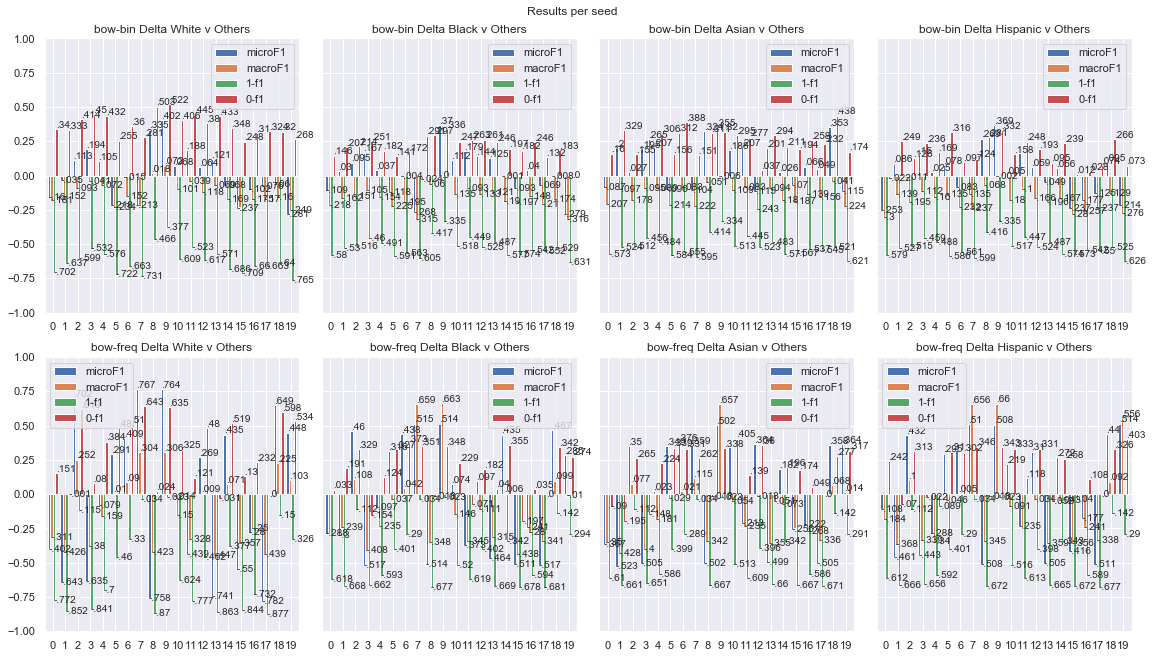

In [45]:
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,9))
LIM = 1

plots.plot_df(df=df_bb_delta_W,ax=ax[0][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bb_delta_N,ax=ax[0][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bb_delta_A,ax=ax[0][2],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bb_delta_H,ax=ax[0][3],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)

plots.plot_df(df=df_bf_delta_W,ax=ax[1][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bf_delta_N,ax=ax[1][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bf_delta_A,ax=ax[1][2],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bf_delta_H,ax=ax[1][3],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)

ax[0][0].set_title("bow-bin Delta White v Others")
ax[0][1].set_title("bow-bin Delta Black v Others")
ax[0][2].set_title("bow-bin Delta Asian v Others")
ax[0][3].set_title("bow-bin Delta Hispanic v Others")

ax[1][0].set_title("bow-freq Delta White v Others")
ax[1][1].set_title("bow-freq Delta Black v Others")
ax[1][2].set_title("bow-freq Delta Asian v Others")
ax[1][3].set_title("bow-freq Delta Hispanic v Others")

ax[0][0].legend(loc='best')
ax[0][1].legend(loc='best')
ax[0][2].legend(loc='best')
ax[0][3].legend(loc='best')
ax[1][0].legend(loc='best')
ax[1][1].legend(loc='best')
ax[1][2].legend(loc='best')
ax[1][3].legend(loc='best')

plt.tight_layout()
fig.suptitle("Results per seed",y=1.01)

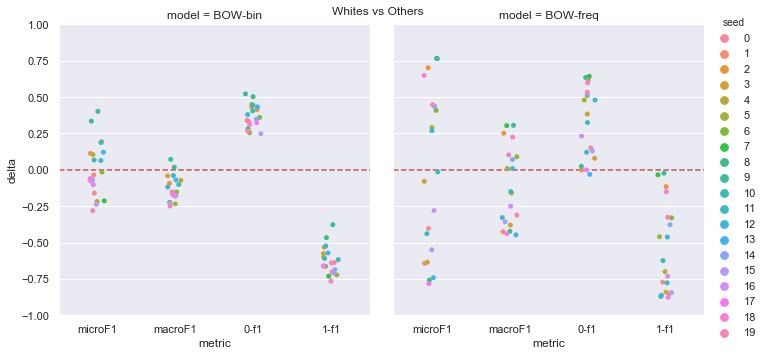

In [46]:
df_delta_long_W = df_bb_delta_long_W.append(df_bf_delta_long_W)
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_W, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-LIM,LIM])
ax2.set_ylim([-LIM,LIM])
plt.suptitle("Whites vs Others")
g

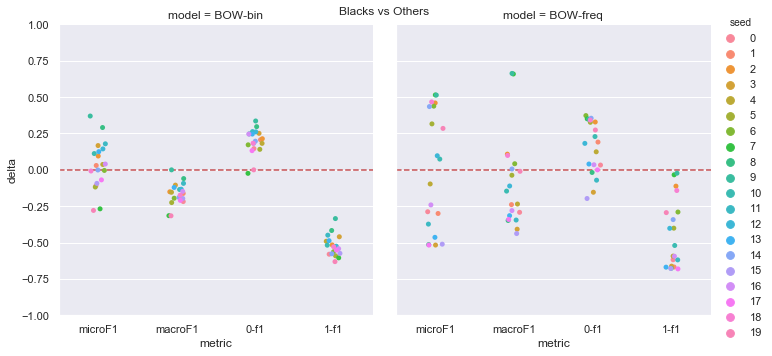

In [47]:
df_delta_long_N = df_bb_delta_long_N.append(df_bf_delta_long_N)
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_N, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-LIM,LIM])
ax2.set_ylim([-LIM,LIM])
plt.suptitle("Blacks vs Others")
g

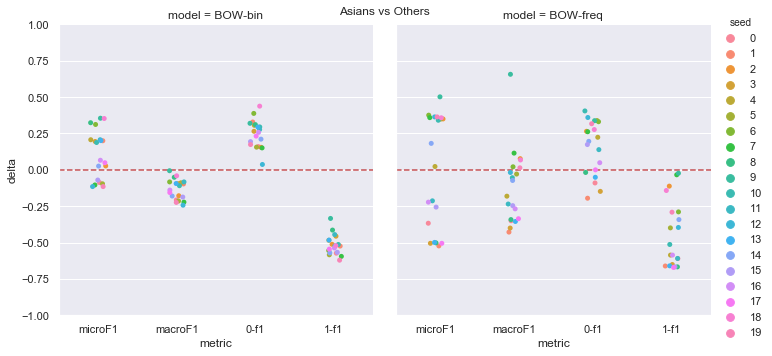

In [48]:
df_delta_long_A = df_bb_delta_long_A.append(df_bf_delta_long_A)
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_A, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-LIM,LIM])
ax2.set_ylim([-LIM,LIM])
plt.suptitle("Asians vs Others")
g

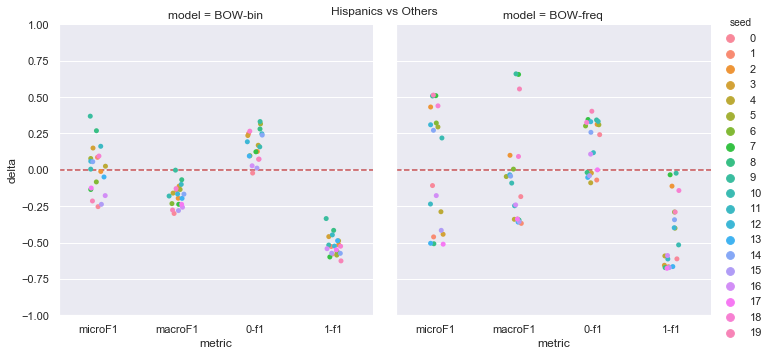

In [49]:
df_delta_long_H = df_bb_delta_long_H.append(df_bf_delta_long_H)
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_H, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-LIM,LIM])
ax2.set_ylim([-LIM,LIM])
plt.suptitle("Hispanics vs Others")
g

## Readmissions

In [50]:
df = df_readmission
x_label = "TEXT"
y_label = "READMISSION"

results_BOW_M_W, results_BOW_F_W = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "WHITE", split=0.8)
results_BOW_M_N, results_BOW_F_N = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "BLACK", split=0.8)
results_BOW_M_A, results_BOW_F_A = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "ASIAN", split=0.8)
results_BOW_M_H, results_BOW_F_H = run(df, x_label, y_label, "BOW-bin", "ETHNICITY_LABEL", "HISPANIC", split=0.8)

results_BOW_freq_M_W, results_BOW_freq_F_W = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "WHITE", split=0.8)
results_BOW_freq_M_N, results_BOW_freq_F_N = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "BLACK", split=0.8)
results_BOW_freq_M_A, results_BOW_freq_F_A = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "ASIAN", split=0.8)
results_BOW_freq_M_H, results_BOW_freq_F_H = run(df, x_label, y_label, "BOW-freq", "ETHNICITY_LABEL", "HISPANIC", split=0.8)



M: 245 | F: 435


/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:512: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not i.flags.writeable or i.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:514: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not j.flags.writeable or j.dtype not in (np.int32, np.int64):
/Users/samir/anaconda3/lib/python3.6/site-packages/scipy/sparse/lil.py:518: FutureWarning: future versions will not create a writeable array from broadcast_array. Set the writable flag explicitly to avoid this warning.
  if not x.flags.writeable:


(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-bin| seed: 0| acc: 0.412| microF1: 0.412| macroF1: 0.292| 0-f1: 0.584| 1-f1: 0.0| 
** model: BOW-bin| seed: 0| acc: 0.572| microF1: 0.572| macroF1: 0.473| 0-f1: 0.244| 1-f1: 0.702| 
[running seed: 1]
** model: BOW-bin| seed: 1| acc: 0.494| microF1: 0.494| macroF1: 0.331| 0-f1: 0.661| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6

** model: BOW-bin| seed: 1| acc: 0.529| microF1: 0.529| macroF1: 0.483| 0-f1: 0.328| 1-f1: 0.637| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.616| microF1: 0.616| macroF1: 0.381| 0-f1: 0.763| 1-f1: 0.0| 
** model: BOW-bin| seed: 2| acc: 0.503| microF1: 0.503| macroF1: 0.474| 0-f1: 0.349| 1-f1: 0.599| 
[running seed: 3]
** model: BOW-bin| seed: 3| acc: 0.645| microF1: 0.645| macroF1: 0.392| 0-f1: 0.784| 1-f1: 0.0| 
** model: BOW-bin| seed: 3| acc: 0.451| microF1: 0.451| macroF1: 0.433| 0-f1: 0.334| 1-f1: 0.532| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.576| microF1: 0.576| macroF1: 0.365| 0-f1: 0.731| 1-f1: 0.0| 
** model: BOW-bin| seed: 4| acc: 0.471| microF1: 0.471| macroF1: 0.437| 0-f1: 0.299| 1-f1: 0.576| 
[running seed: 5]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 5| acc: 0.384| microF1: 0.384| macroF1: 0.277| 0-f1: 0.555| 1-f1: 0.0| 
** model: BOW-bin| seed: 5| acc: 0.602| microF1: 0.602| macroF1: 0.511| 0-f1: 0.3| 1-f1: 0.722| 
[running seed: 6]
** model: BOW-bin| seed: 6| acc: 0.539| microF1: 0.539| macroF1: 0.35| 0-f1: 0.7| 1-f1: 0.0| 
** model: BOW-bin| seed: 6| acc: 0.554| microF1: 0.554| macroF1: 0.502| 0-f1: 0.34| 1-f1: 0.663| 
[running seed: 7]
** model: BOW-bin| seed: 7| acc: 0.396| microF1: 0.396| macroF1: 0.284| 0-f1: 0.567| 1-f1: 0.0| 
** model: BOW-bin| seed: 7| acc: 0.609| microF1: 0.609| macroF1: 0.508| 0-f1: 0.286| 1-f1: 0.731| 
[running seed: 8]
** model: BOW-bin| seed: 8| acc: 0.751| microF1: 0.751| macroF1: 0.429| 0-f1: 0.858| 1-f1: 0.0| 
** model: BOW-bin| seed: 8| acc: 0.416| microF1: 0.416| macroF1: 0.411| 0-f1: 0.355| 1-f1: 0.466| 
[running seed: 9]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 9| acc: 0.763| microF1: 0.763| macroF1: 0.433| 0-f1: 0.866| 1-f1: 0.0| 
** model: BOW-bin| seed: 9| acc: 0.361| microF1: 0.361| macroF1: 0.361| 0-f1: 0.344| 1-f1: 0.377| 
[running seed: 10]
** model: BOW-bin| seed: 10| acc: 0.571| microF1: 0.571| macroF1: 0.364| 0-f1: 0.727| 1-f1: 0.0| 
** model: BOW-bin| seed: 10| acc: 0.503| microF1: 0.503| macroF1: 0.465| 0-f1: 0.321| 1-f1: 0.609| 
[running seed: 11]
** model: BOW-bin| seed: 11| acc: 0.629| microF1: 0.629| macroF1: 0.386| 0-f1: 0.772| 1-f1: 0.0| 
** model: BOW-bin| seed: 11| acc: 0.441| microF1: 0.441| macroF1: 0.425| 0-f1: 0.327| 1-f1: 0.523| 
[running seed: 12]
** model: BOW-bin| seed: 12| acc: 0.584| microF1: 0.584| macroF1: 0.369| 0-f1: 0.737| 1-f1: 0.0| 
** model: BOW-bin| seed: 12| acc: 0.52| microF1: 0.52| macroF1: 0.487| 0-f1: 0.357| 1-f1: 0.617| 
[running seed: 13]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 13| acc: 0.592| microF1: 0.592| macroF1: 0.372| 0-f1: 0.744| 1-f1: 0.0| 
** model: BOW-bin| seed: 13| acc: 0.471| microF1: 0.471| macroF1: 0.441| 0-f1: 0.311| 1-f1: 0.571| 
[running seed: 14]
** model: BOW-bin| seed: 14| acc: 0.502| microF1: 0.502| macroF1: 0.334| 0-f1: 0.668| 1-f1: 0.0| 
** model: BOW-bin| seed: 14| acc: 0.57| microF1: 0.57| macroF1: 0.503| 0-f1: 0.32| 1-f1: 0.686| 
[running seed: 15]
** model: BOW-bin| seed: 15| acc: 0.347| microF1: 0.347| macroF1: 0.258| 0-f1: 0.515| 1-f1: 0.0| 
** model: BOW-bin| seed: 15| acc: 0.584| microF1: 0.584| macroF1: 0.488| 0-f1: 0.267| 1-f1: 0.709| 
[running seed: 16]
** model: BOW-bin| seed: 16| acc: 0.441| microF1: 0.441| macroF1: 0.306| 0-f1: 0.612| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 16| acc: 0.543| microF1: 0.543| macroF1: 0.481| 0-f1: 0.302| 1-f1: 0.66| 
[running seed: 17]
** model: BOW-bin| seed: 17| acc: 0.473| microF1: 0.473| macroF1: 0.321| 0-f1: 0.643| 1-f1: 0.0| 
** model: BOW-bin| seed: 17| acc: 0.549| microF1: 0.549| macroF1: 0.491| 0-f1: 0.319| 1-f1: 0.663| 
[running seed: 18]
** model: BOW-bin| seed: 18| acc: 0.469| microF1: 0.469| macroF1: 0.319| 0-f1: 0.639| 1-f1: 0.0| 
** model: BOW-bin| seed: 18| acc: 0.529| microF1: 0.529| macroF1: 0.479| 0-f1: 0.319| 1-f1: 0.64| 
[running seed: 19]
** model: BOW-bin| seed: 19| acc: 0.363| microF1: 0.363| macroF1: 0.266| 0-f1: 0.533| 1-f1: 0.0| 
** model: BOW-bin| seed: 19| acc: 0.644| microF1: 0.644| macroF1: 0.515| 0-f1: 0.265| 1-f1: 0.765| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


M: 22 | F: 658
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-bin| seed: 0| acc: 0.409| microF1: 0.409| macroF1: 0.29| 0-f1: 0.581| 1-f1: 0.0| 
** model: BOW-bin| seed: 0| acc: 0.518| microF1: 0.518| macroF1: 0.508| 0-f1: 0.435| 1-f1: 0.58| 
[running seed: 1]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 1| acc: 0.545| microF1: 0.545| macroF1: 0.353| 0-f1: 0.706| 1-f1: 0.0| 
** model: BOW-bin| seed: 1| acc: 0.515| microF1: 0.515| macroF1: 0.515| 0-f1: 0.499| 1-f1: 0.53| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.636| microF1: 0.636| macroF1: 0.389| 0-f1: 0.778| 1-f1: 0.0| 
** model: BOW-bin| seed: 2| acc: 0.541| microF1: 0.541| macroF1: 0.54| 0-f1: 0.564| 1-f1: 0.516| 
[running seed: 3]
** model: BOW-bin| seed: 3| acc: 0.682| microF1: 0.682| macroF1: 0.405| 0-f1: 0.811| 1-f1: 0.0| 
** model: BOW-bin| seed: 3| acc: 0.515| microF1: 0.515| macroF1: 0.51| 0-f1: 0.56| 1-f1: 0.46| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.545| microF1: 0.545| macroF1: 0.353| 0-f1: 0.706| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 4| acc: 0.508| microF1: 0.508| macroF1: 0.507| 0-f1: 0.524| 1-f1: 0.491| 
[running seed: 5]
** model: BOW-bin| seed: 5| acc: 0.409| microF1: 0.409| macroF1: 0.29| 0-f1: 0.581| 1-f1: 0.0| 
** model: BOW-bin| seed: 5| acc: 0.527| microF1: 0.527| macroF1: 0.515| 0-f1: 0.44| 1-f1: 0.591| 
[running seed: 6]
** model: BOW-bin| seed: 6| acc: 0.545| microF1: 0.545| macroF1: 0.353| 0-f1: 0.706| 1-f1: 0.0| 
** model: BOW-bin| seed: 6| acc: 0.549| microF1: 0.549| macroF1: 0.548| 0-f1: 0.534| 1-f1: 0.563| 
[running seed: 7]
** model: BOW-bin| seed: 7| acc: 0.273| microF1: 0.273| macroF1: 0.214| 0-f1: 0.429| 1-f1: 0.0| 
** model: BOW-bin| seed: 7| acc: 0.541| microF1: 0.541| macroF1: 0.529| 0-f1: 0.453| 1-f1: 0.605| 
[running seed: 8]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 8| acc: 0.818| microF1: 0.818| macroF1: 0.45| 0-f1: 0.9| 1-f1: 0.0| 
** model: BOW-bin| seed: 8| acc: 0.527| microF1: 0.527| macroF1: 0.51| 0-f1: 0.603| 1-f1: 0.417| 
[running seed: 9]
** model: BOW-bin| seed: 9| acc: 0.864| microF1: 0.864| macroF1: 0.463| 0-f1: 0.927| 1-f1: 0.0| 
** model: BOW-bin| seed: 9| acc: 0.494| microF1: 0.494| macroF1: 0.463| 0-f1: 0.591| 1-f1: 0.335| 
[running seed: 10]
** model: BOW-bin| seed: 10| acc: 0.636| microF1: 0.636| macroF1: 0.389| 0-f1: 0.778| 1-f1: 0.0| 
** model: BOW-bin| seed: 10| acc: 0.524| microF1: 0.524| macroF1: 0.524| 0-f1: 0.531| 1-f1: 0.518| 
[running seed: 11]
** model: BOW-bin| seed: 11| acc: 0.682| microF1: 0.682| macroF1: 0.405| 0-f1: 0.811| 1-f1: 0.0| 
** model: BOW-bin| seed: 11| acc: 0.503| microF1: 0.503| macroF1: 0.498| 0-f1: 0.548| 1-f1: 0.449| 
[running seed: 12]
** model: BOW-bin| seed: 12| acc: 0.682| microF1: 0.682| macroF1: 0.405| 0-f1: 0.811| 1-f1: 0.0| 
** model: BOW-bin| seed: 12| acc: 0.538| mi

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 13| acc: 0.636| microF1: 0.636| macroF1: 0.389| 0-f1: 0.778| 1-f1: 0.0| 
** model: BOW-bin| seed: 13| acc: 0.511| microF1: 0.511| macroF1: 0.51| 0-f1: 0.532| 1-f1: 0.487| 
[running seed: 14]
** model: BOW-bin| seed: 14| acc: 0.545| microF1: 0.545| macroF1: 0.353| 0-f1: 0.706| 1-f1: 0.0| 
** model: BOW-bin| seed: 14| acc: 0.546| microF1: 0.546| macroF1: 0.543| 0-f1: 0.509| 1-f1: 0.577| 
[running seed: 15]
** model: BOW-bin| seed: 15| acc: 0.409| microF1: 0.409| macroF1: 0.29| 0-f1: 0.581| 1-f1: 0.0| 
** model: BOW-bin| seed: 15| acc: 0.502| microF1: 0.502| macroF1: 0.487| 0-f1: 0.399| 1-f1: 0.574| 
[running seed: 16]
** model: BOW-bin| seed: 16| acc: 0.545| microF1: 0.545| macroF1: 0.353| 0-f1: 0.706| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 16| acc: 0.505| microF1: 0.505| macroF1: 0.501| 0-f1: 0.46| 1-f1: 0.542| 
[running seed: 17]
** model: BOW-bin| seed: 17| acc: 0.455| microF1: 0.455| macroF1: 0.312| 0-f1: 0.625| 1-f1: 0.0| 
** model: BOW-bin| seed: 17| acc: 0.524| microF1: 0.524| macroF1: 0.522| 0-f1: 0.493| 1-f1: 0.552| 
[running seed: 18]
** model: BOW-bin| seed: 18| acc: 0.5| microF1: 0.5| macroF1: 0.333| 0-f1: 0.667| 1-f1: 0.0| 
** model: BOW-bin| seed: 18| acc: 0.508| microF1: 0.508| macroF1: 0.507| 0-f1: 0.484| 1-f1: 0.529| 
[running seed: 19]
** model: BOW-bin| seed: 19| acc: 0.273| microF1: 0.273| macroF1: 0.214| 0-f1: 0.429| 1-f1: 0.0| 
** model: BOW-bin| seed: 19| acc: 0.552| microF1: 0.552| macroF1: 0.53| 0-f1: 0.429| 1-f1: 0.631| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


M: 7 | F: 673
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-bin| seed: 0| acc: 0.429| microF1: 0.429| macroF1: 0.3| 0-f1: 0.6| 1-f1: 0.0| 
** model: BOW-bin| seed: 0| acc: 0.516| microF1: 0.516| macroF1: 0.507| 0-f1: 0.44| 1-f1: 0.573| 
[running seed: 1]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 1| acc: 0.714| microF1: 0.714| macroF1: 0.417| 0-f1: 0.833| 1-f1: 0.0| 
** model: BOW-bin| seed: 1| acc: 0.514| microF1: 0.514| macroF1: 0.514| 0-f1: 0.504| 1-f1: 0.524| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.571| microF1: 0.571| macroF1: 0.364| 0-f1: 0.727| 1-f1: 0.0| 
** model: BOW-bin| seed: 2| acc: 0.544| microF1: 0.544| macroF1: 0.542| 0-f1: 0.572| 1-f1: 0.512| 
[running seed: 3]
** model: BOW-bin| seed: 3| acc: 0.714| microF1: 0.714| macroF1: 0.417| 0-f1: 0.833| 1-f1: 0.0| 
** model: BOW-bin| seed: 3| acc: 0.519| microF1: 0.519| macroF1: 0.512| 0-f1: 0.568| 1-f1: 0.456| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.714| microF1: 0.714| macroF1: 0.417| 0-f1: 0.833| 1-f1: 0.0| 
** model: BOW-bin| seed: 4| acc: 0.507| microF1: 0.507| macroF1: 0.506| 0-f1: 0.527| 1-f1: 0.484| 
[running seed: 5]
** model: BOW-bin| seed: 5| acc: 0.429| microF1: 0.429| macroF1: 0.3| 0-f1: 0.6| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 5| acc: 0.525| microF1: 0.525| macroF1: 0.514| 0-f1: 0.444| 1-f1: 0.584| 
[running seed: 6]
** model: BOW-bin| seed: 6| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-bin| seed: 6| acc: 0.545| microF1: 0.545| macroF1: 0.545| 0-f1: 0.535| 1-f1: 0.555| 
[running seed: 7]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-bin| seed: 7| acc: 0.429| microF1: 0.429| macroF1: 0.3| 0-f1: 0.6| 1-f1: 0.0| 
** model: BOW-bin| seed: 7| acc: 0.533| microF1: 0.533| macroF1: 0.522| 0-f1: 0.449| 1-f1: 0.595| 
[running seed: 8]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-bin| seed: 8| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-bin| seed: 8| acc: 0.533| microF1: 0.533| macroF1: 0.513| 0-f1: 0.612| 1-f1: 0.414| 
[running seed: 9]
** model: BOW-bin| seed: 9| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-bin| seed: 9| acc: 0.502| microF1: 0.502| macroF1: 0.468| 0-f1: 0.603| 1-f1: 0.334| 
[running seed: 10]
** model: BOW-bin| seed: 10| acc: 0.714| microF1: 0.714| macroF1: 0.417| 0-f1: 0.833| 1-f1: 0.0| 
** model: BOW-bin| seed: 10| acc: 0.526| microF1: 0.526| macroF1: 0.526| 0-f1: 0.538| 1-f1: 0.513| 
[running seed: 11]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-bin| seed: 11| acc: 0.714| microF1: 0.714| macroF1: 0.417| 0-f1: 0.833| 1-f1: 0.0| 
** model: BOW-bin| seed: 11| acc: 0.507| microF1: 0.507| macroF1: 0.5| 0-f1: 0.556| 1-f1: 0.445| 
[running seed: 12]
** model: BOW-bin| seed: 12| acc: 0.429| microF1: 0.429| macroF1: 0.3| 0-f1: 0.6| 1-f1: 0.0| 
** model: BOW-bin| seed: 12| acc: 0.544| microF1: 0.544| macroF1: 0.543| 0-f1: 0.563| 1-f1: 0.523| 
[running seed: 13]
** model: BOW-bin| seed: 13| acc: 0.714| microF1: 0.714| macroF1: 0.417| 0-f1: 0.833| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 13| acc: 0.513| microF1: 0.513| macroF1: 0.511| 0-f1: 0.539| 1-f1: 0.483| 
[running seed: 14]
** model: BOW-bin| seed: 14| acc: 0.571| microF1: 0.571| macroF1: 0.364| 0-f1: 0.727| 1-f1: 0.0| 
** model: BOW-bin| seed: 14| acc: 0.545| microF1: 0.545| macroF1: 0.544| 0-f1: 0.516| 1-f1: 0.571| 
[running seed: 15]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-bin| seed: 15| acc: 0.429| microF1: 0.429| macroF1: 0.3| 0-f1: 0.6| 1-f1: 0.0| 
** model: BOW-bin| seed: 15| acc: 0.499| microF1: 0.499| macroF1: 0.487| 0-f1: 0.406| 1-f1: 0.567| 
[running seed: 16]
** model: BOW-bin| seed: 16| acc: 0.571| microF1: 0.571| macroF1: 0.364| 0-f1: 0.727| 1-f1: 0.0| 
** model: BOW-bin| seed: 16| acc: 0.505| microF1: 0.505| macroF1: 0.503| 0-f1: 0.469| 1-f1: 0.537| 
[running seed: 17]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 17| acc: 0.571| microF1: 0.571| macroF1: 0.364| 0-f1: 0.727| 1-f1: 0.0| 
** model: BOW-bin| seed: 17| acc: 0.522| microF1: 0.522| macroF1: 0.52| 0-f1: 0.495| 1-f1: 0.545| 
[running seed: 18]
** model: BOW-bin| seed: 18| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-bin| seed: 18| acc: 0.504| microF1: 0.504| macroF1: 0.503| 0-f1: 0.485| 1-f1: 0.521| 
[running seed: 19]
** model: BOW-bin| seed: 19| acc: 0.429| microF1: 0.429| macroF1: 0.3| 0-f1: 0.6| 1-f1: 0.0| 
** model: BOW-bin| seed: 19| acc: 0.544| microF1: 0.544| macroF1: 0.524| 0-f1: 0.426| 1-f1: 0.621| 
M: 15 | F: 665
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-bin| seed: 0| acc: 0.267| microF1: 0.267| macroF1: 0.211| 0-f1: 0.421| 1-f1: 0.0| 
** model: BOW-bin| seed: 0| acc: 0.52| microF1: 0.52| macroF1: 0.511| 0-f1: 0.443| 1-f1: 0.579| 
[running seed: 1]
** model: BOW-bin| seed: 1| acc: 0.6| microF1: 0.6| macroF1: 0.375| 0-f1: 0.75| 1-f1: 0.0

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 1| acc: 0.514| microF1: 0.514| macroF1: 0.514| 0-f1: 0.501| 1-f1: 0.527| 
[running seed: 2]
** model: BOW-bin| seed: 2| acc: 0.533| microF1: 0.533| macroF1: 0.348| 0-f1: 0.696| 1-f1: 0.0| 
** model: BOW-bin| seed: 2| acc: 0.544| microF1: 0.544| macroF1: 0.543| 0-f1: 0.57| 1-f1: 0.515| 
[running seed: 3]
** model: BOW-bin| seed: 3| acc: 0.667| microF1: 0.667| macroF1: 0.4| 0-f1: 0.8| 1-f1: 0.0| 
** model: BOW-bin| seed: 3| acc: 0.517| microF1: 0.517| macroF1: 0.512| 0-f1: 0.564| 1-f1: 0.459| 
[running seed: 4]
** model: BOW-bin| seed: 4| acc: 0.533| microF1: 0.533| macroF1: 0.348| 0-f1: 0.696| 1-f1: 0.0| 
** model: BOW-bin| seed: 4| acc: 0.508| microF1: 0.508| macroF1: 0.508| 0-f1: 0.527| 1-f1: 0.488| 
[running seed: 5]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 5| acc: 0.6| microF1: 0.6| macroF1: 0.375| 0-f1: 0.75| 1-f1: 0.0| 
** model: BOW-bin| seed: 5| acc: 0.522| microF1: 0.522| macroF1: 0.51| 0-f1: 0.434| 1-f1: 0.586| 
[running seed: 6]
** model: BOW-bin| seed: 6| acc: 0.467| microF1: 0.467| macroF1: 0.318| 0-f1: 0.636| 1-f1: 0.0| 
** model: BOW-bin| seed: 6| acc: 0.55| microF1: 0.55| macroF1: 0.55| 0-f1: 0.539| 1-f1: 0.561| 
[running seed: 7]
** model: BOW-bin| seed: 7| acc: 0.4| microF1: 0.4| macroF1: 0.286| 0-f1: 0.571| 1-f1: 0.0| 
** model: BOW-bin| seed: 7| acc: 0.535| microF1: 0.535| macroF1: 0.523| 0-f1: 0.447| 1-f1: 0.599| 
[running seed: 8]
** model: BOW-bin| seed: 8| acc: 0.8| microF1: 0.8| macroF1: 0.444| 0-f1: 0.889| 1-f1: 0.0| 
** model: BOW-bin| seed: 8| acc: 0.531| microF1: 0.531| macroF1: 0.512| 0-f1: 0.608| 1-f1: 0.416| 
[running seed: 9]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 9| acc: 0.867| microF1: 0.867| macroF1: 0.464| 0-f1: 0.929| 1-f1: 0.0| 
** model: BOW-bin| seed: 9| acc: 0.498| microF1: 0.498| macroF1: 0.466| 0-f1: 0.597| 1-f1: 0.335| 
[running seed: 10]
** model: BOW-bin| seed: 10| acc: 0.533| microF1: 0.533| macroF1: 0.348| 0-f1: 0.696| 1-f1: 0.0| 
** model: BOW-bin| seed: 10| acc: 0.528| microF1: 0.528| macroF1: 0.528| 0-f1: 0.538| 1-f1: 0.517| 
[running seed: 11]
** model: BOW-bin| seed: 11| acc: 0.667| microF1: 0.667| macroF1: 0.4| 0-f1: 0.8| 1-f1: 0.0| 
** model: BOW-bin| seed: 11| acc: 0.505| microF1: 0.505| macroF1: 0.5| 0-f1: 0.552| 1-f1: 0.447| 
[running seed: 12]
** model: BOW-bin| seed: 12| acc: 0.6| microF1: 0.6| macroF1: 0.375| 0-f1: 0.75| 1-f1: 0.0| 
** model: BOW-bin| seed: 12| acc: 0.541| microF1: 0.541| macroF1: 0.541| 0-f1: 0.557| 1-f1: 0.524| 
[running seed: 13]
** model: BOW-bin| seed: 13| acc: 0.467| microF1: 0.467| macroF1: 0.318| 0-f1: 0.636| 1-f1: 0.0| 
** model: BOW-bin| seed: 13| acc: 0.516| microF

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 15| acc: 0.267| microF1: 0.267| macroF1: 0.211| 0-f1: 0.421| 1-f1: 0.0| 
** model: BOW-bin| seed: 15| acc: 0.504| microF1: 0.504| macroF1: 0.491| 0-f1: 0.409| 1-f1: 0.573| 
[running seed: 16]
** model: BOW-bin| seed: 16| acc: 0.333| microF1: 0.333| macroF1: 0.25| 0-f1: 0.5| 1-f1: 0.0| 
** model: BOW-bin| seed: 16| acc: 0.51| microF1: 0.51| macroF1: 0.507| 0-f1: 0.472| 1-f1: 0.542| 
[running seed: 17]
** model: BOW-bin| seed: 17| acc: 0.4| microF1: 0.4| macroF1: 0.286| 0-f1: 0.571| 1-f1: 0.0| 
** model: BOW-bin| seed: 17| acc: 0.525| microF1: 0.525| macroF1: 0.523| 0-f1: 0.497| 1-f1: 0.55| 
[running seed: 18]
** model: BOW-bin| seed: 18| acc: 0.6| microF1: 0.6| macroF1: 0.375| 0-f1: 0.75| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-bin| seed: 18| acc: 0.505| microF1: 0.505| macroF1: 0.504| 0-f1: 0.484| 1-f1: 0.525| 
[running seed: 19]
** model: BOW-bin| seed: 19| acc: 0.333| microF1: 0.333| macroF1: 0.25| 0-f1: 0.5| 1-f1: 0.0| 
** model: BOW-bin| seed: 19| acc: 0.547| microF1: 0.547| macroF1: 0.526| 0-f1: 0.427| 1-f1: 0.626| 
M: 245 | F: 435
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-freq| seed: 0| acc: 0.249| microF1: 0.249| macroF1: 0.199| 0-f1: 0.399| 1-f1: 0.0| 
** model: BOW-freq| seed: 0| acc: 0.651| microF1: 0.651| macroF1: 0.51| 0-f1: 0.248| 1-f1: 0.772| 
[running seed: 1]
** model: BOW-freq| seed: 1| acc: 0.106| microF1: 0.106| macroF1: 0.096| 0-f1: 0.192| 1-f1: 0.0| 
** model: BOW-freq| seed: 1| acc: 0.749| microF1: 0.749| macroF1: 0.522| 0-f1: 0.193| 1-f1: 0.852| 
[running seed: 2]
** model: BOW-freq| seed: 2| acc: 0.959| microF1: 0.959| macroF1: 0.49| 0-f1: 0.979| 1-f1: 0.0| 
** model: BOW-freq| seed: 2| acc: 0.257| microF1: 0.257| macroF1: 0.238| 0-f1: 0.36| 

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 3| acc: 0.094| microF1: 0.094| macroF1: 0.086| 0-f1: 0.172| 1-f1: 0.0| 
** model: BOW-freq| seed: 3| acc: 0.729| microF1: 0.729| macroF1: 0.466| 0-f1: 0.092| 1-f1: 0.841| 
[running seed: 4]
** model: BOW-freq| seed: 4| acc: 0.498| microF1: 0.498| macroF1: 0.332| 0-f1: 0.665| 1-f1: 0.0| 
** model: BOW-freq| seed: 4| acc: 0.577| microF1: 0.577| macroF1: 0.491| 0-f1: 0.281| 1-f1: 0.7| 
[running seed: 5]
** model: BOW-freq| seed: 5| acc: 0.698| microF1: 0.698| macroF1: 0.411| 0-f1: 0.822| 1-f1: 0.0| 
** model: BOW-freq| seed: 5| acc: 0.407| microF1: 0.407| macroF1: 0.401| 0-f1: 0.342| 1-f1: 0.46| 
[running seed: 6]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 6| acc: 0.747| microF1: 0.747| macroF1: 0.428| 0-f1: 0.855| 1-f1: 0.0| 
** model: BOW-freq| seed: 6| acc: 0.338| microF1: 0.338| macroF1: 0.338| 0-f1: 0.345| 1-f1: 0.33| 
[running seed: 7]
** model: BOW-freq| seed: 7| acc: 0.992| microF1: 0.992| macroF1: 0.498| 0-f1: 0.996| 1-f1: 0.0| 
** model: BOW-freq| seed: 7| acc: 0.225| microF1: 0.225| macroF1: 0.194| 0-f1: 0.353| 1-f1: 0.034| 
[running seed: 8]
** model: BOW-freq| seed: 8| acc: 0.012| microF1: 0.012| macroF1: 0.012| 0-f1: 0.024| 1-f1: 0.0| 
** model: BOW-freq| seed: 8| acc: 0.77| microF1: 0.77| macroF1: 0.435| 0-f1: 0.0| 1-f1: 0.87| 
[running seed: 9]
** model: BOW-freq| seed: 9| acc: 0.992| microF1: 0.992| macroF1: 0.498| 0-f1: 0.996| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 9| acc: 0.228| microF1: 0.228| macroF1: 0.192| 0-f1: 0.361| 1-f1: 0.023| 
[running seed: 10]
** model: BOW-freq| seed: 10| acc: 0.51| microF1: 0.51| macroF1: 0.338| 0-f1: 0.676| 1-f1: 0.0| 
** model: BOW-freq| seed: 10| acc: 0.524| microF1: 0.524| macroF1: 0.488| 0-f1: 0.351| 1-f1: 0.624| 
[running seed: 11]
** model: BOW-freq| seed: 11| acc: 0.216| microF1: 0.216| macroF1: 0.178| 0-f1: 0.356| 1-f1: 0.0| 
** model: BOW-freq| seed: 11| acc: 0.655| microF1: 0.655| macroF1: 0.506| 0-f1: 0.235| 1-f1: 0.777| 
[running seed: 12]
** model: BOW-freq| seed: 12| acc: 0.669| microF1: 0.669| macroF1: 0.401| 0-f1: 0.802| 1-f1: 0.0| 
** model: BOW-freq| seed: 12| acc: 0.4| microF1: 0.4| macroF1: 0.392| 0-f1: 0.322| 1-f1: 0.462| 
[running seed: 13]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 13| acc: 0.02| microF1: 0.02| macroF1: 0.02| 0-f1: 0.04| 1-f1: 0.0| 
** model: BOW-freq| seed: 13| acc: 0.761| microF1: 0.761| macroF1: 0.467| 0-f1: 0.071| 1-f1: 0.863| 
[running seed: 14]
** model: BOW-freq| seed: 14| acc: 0.812| microF1: 0.812| macroF1: 0.448| 0-f1: 0.896| 1-f1: 0.0| 
** model: BOW-freq| seed: 14| acc: 0.377| microF1: 0.377| macroF1: 0.377| 0-f1: 0.377| 1-f1: 0.377| 
[running seed: 15]
** model: BOW-freq| seed: 15| acc: 0.188| microF1: 0.188| macroF1: 0.158| 0-f1: 0.316| 1-f1: 0.0| 
** model: BOW-freq| seed: 15| acc: 0.738| microF1: 0.738| macroF1: 0.515| 0-f1: 0.186| 1-f1: 0.844| 
[running seed: 16]
** model: BOW-freq| seed: 16| acc: 0.327| microF1: 0.327| macroF1: 0.246| 0-f1: 0.492| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 16| acc: 0.607| microF1: 0.607| macroF1: 0.496| 0-f1: 0.26| 1-f1: 0.732| 
[running seed: 17]
** model: BOW-freq| seed: 17| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 17| acc: 0.782| microF1: 0.782| macroF1: 0.439| 0-f1: 0.0| 1-f1: 0.877| 
[running seed: 18]
** model: BOW-freq| seed: 18| acc: 0.918| microF1: 0.918| macroF1: 0.479| 0-f1: 0.957| 1-f1: 0.0| 
** model: BOW-freq| seed: 18| acc: 0.269| microF1: 0.269| macroF1: 0.254| 0-f1: 0.359| 1-f1: 0.15| 
[running seed: 19]
** model: BOW-freq| seed: 19| acc: 0.784| microF1: 0.784| macroF1: 0.439| 0-f1: 0.879| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 19| acc: 0.336| microF1: 0.336| macroF1: 0.336| 0-f1: 0.345| 1-f1: 0.326| 
M: 22 | F: 658
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-freq| seed: 0| acc: 0.227| microF1: 0.227| macroF1: 0.185| 0-f1: 0.37| 1-f1: 0.0| 
** model: BOW-freq| seed: 0| acc: 0.515| microF1: 0.515| macroF1: 0.477| 0-f1: 0.337| 1-f1: 0.618| 
[running seed: 1]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 1| acc: 0.227| microF1: 0.227| macroF1: 0.185| 0-f1: 0.37| 1-f1: 0.0| 
** model: BOW-freq| seed: 1| acc: 0.527| microF1: 0.527| macroF1: 0.424| 0-f1: 0.179| 1-f1: 0.668| 
[running seed: 2]
** model: BOW-freq| seed: 2| acc: 0.955| microF1: 0.955| macroF1: 0.488| 0-f1: 0.977| 1-f1: 0.0| 
** model: BOW-freq| seed: 2| acc: 0.495| microF1: 0.495| macroF1: 0.38| 0-f1: 0.648| 1-f1: 0.112| 
[running seed: 3]
** model: BOW-freq| seed: 3| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 3| acc: 0.517| microF1: 0.517| macroF1: 0.408| 0-f1: 0.154| 1-f1: 0.662| 
[running seed: 4]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/

** model: BOW-freq| seed: 4| acc: 0.455| microF1: 0.455| macroF1: 0.312| 0-f1: 0.625| 1-f1: 0.0| 
** model: BOW-freq| seed: 4| acc: 0.552| microF1: 0.552| macroF1: 0.547| 0-f1: 0.501| 1-f1: 0.593| 
[running seed: 5]
** model: BOW-freq| seed: 5| acc: 0.818| microF1: 0.818| macroF1: 0.45| 0-f1: 0.9| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 5| acc: 0.502| microF1: 0.502| macroF1: 0.487| 0-f1: 0.573| 1-f1: 0.401| 
[running seed: 6]
** model: BOW-freq| seed: 6| acc: 0.909| microF1: 0.909| macroF1: 0.476| 0-f1: 0.952| 1-f1: 0.0| 
** model: BOW-freq| seed: 6| acc: 0.471| microF1: 0.471| macroF1: 0.434| 0-f1: 0.579| 1-f1: 0.29| 
[running seed: 7]
** model: BOW-freq| seed: 7| acc: 1.0| microF1: 1.0| macroF1: 1.0| 0-f1: 1.0| 1-f1: 0| 
** model: BOW-freq| seed: 7| acc: 0.485| microF1: 0.485| macroF1: 0.341| 0-f1: 0.649| 1-f1: 0.034| 
[running seed: 8]
** model: BOW-freq| seed: 8| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 8| acc: 0.514| microF1: 0.514| macroF1: 0.348| 0-f1: 0.018| 1-f1: 0.677| 
[running seed: 9]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 9| acc: 1.0| microF1: 1.0| macroF1: 1.0| 0-f1: 1.0| 1-f1: 0| 
** model: BOW-freq| seed: 9| acc: 0.486| microF1: 0.486| macroF1: 0.337| 0-f1: 0.652| 1-f1: 0.023| 
[running seed: 10]
** model: BOW-freq| seed: 10| acc: 0.591| microF1: 0.591| macroF1: 0.371| 0-f1: 0.743| 1-f1: 0.0| 
** model: BOW-freq| seed: 10| acc: 0.517| microF1: 0.517| macroF1: 0.517| 0-f1: 0.514| 1-f1: 0.52| 

/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



[running seed: 11]
** model: BOW-freq| seed: 11| acc: 0.136| microF1: 0.136| macroF1: 0.12| 0-f1: 0.24| 1-f1: 0.0| 
** model: BOW-freq| seed: 11| acc: 0.509| microF1: 0.509| macroF1: 0.465| 0-f1: 0.311| 1-f1: 0.619| 
[running seed: 12]
** model: BOW-freq| seed: 12| acc: 0.591| microF1: 0.591| macroF1: 0.371| 0-f1: 0.743| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 12| acc: 0.494| microF1: 0.494| macroF1: 0.482| 0-f1: 0.561| 1-f1: 0.402| 
[running seed: 13]
** model: BOW-freq| seed: 13| acc: 0.045| microF1: 0.045| macroF1: 0.043| 0-f1: 0.087| 1-f1: 0.0| 
** model: BOW-freq| seed: 13| acc: 0.509| microF1: 0.509| macroF1: 0.358| 0-f1: 0.047| 1-f1: 0.669| 
[running seed: 14]
** model: BOW-freq| seed: 14| acc: 0.955| microF1: 0.955| macroF1: 0.488| 0-f1: 0.977| 1-f1: 0.0| 
** model: BOW-freq| seed: 14| acc: 0.52| microF1: 0.52| macroF1: 0.482| 0-f1: 0.622| 1-f1: 0.342| 
[running seed: 15]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 15| acc: 0.045| microF1: 0.045| macroF1: 0.043| 0-f1: 0.087| 1-f1: 0.0| 
** model: BOW-freq| seed: 15| acc: 0.556| microF1: 0.556| macroF1: 0.481| 0-f1: 0.284| 1-f1: 0.678| 
[running seed: 16]
** model: BOW-freq| seed: 16| acc: 0.273| microF1: 0.273| macroF1: 0.214| 0-f1: 0.429| 1-f1: 0.0| 
** model: BOW-freq| seed: 16| acc: 0.514| microF1: 0.514| macroF1: 0.494| 0-f1: 0.394| 1-f1: 0.594| 
[running seed: 17]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/

** model: BOW-freq| seed: 17| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 17| acc: 0.517| microF1: 0.517| macroF1: 0.341| 0-f1: 0.0| 1-f1: 0.681| 
[running seed: 18]
** model: BOW-freq| seed: 18| acc: 0.955| microF1: 0.955| macroF1: 0.488| 0-f1: 0.977| 1-f1: 0.0| 
** model: BOW-freq| seed: 18| acc: 0.488| microF1: 0.488| macroF1: 0.389| 0-f1: 0.635| 1-f1: 0.142| 
[running seed: 19]
** model: BOW-freq| seed: 19| acc: 0.773| microF1: 0.773| macroF1: 0.436| 0-f1: 0.872| 1-f1: 0.0| 
** model: BOW-freq| seed: 19| acc: 0.488| microF1: 0.488| macroF1: 0.446| 0-f1: 0.598| 1-f1: 0.294| 
M: 7 | F: 673
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-freq| seed: 0| acc: 0.143| microF1: 0.143| macroF1: 0.125| 0-f1: 0.25| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/skle

** model: BOW-freq| seed: 0| acc: 0.51| microF1: 0.51| macroF1: 0.475| 0-f1: 0.34| 1-f1: 0.61| 
[running seed: 1]
** model: BOW-freq| seed: 1| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 1| acc: 0.523| microF1: 0.523| macroF1: 0.428| 0-f1: 0.195| 1-f1: 0.661| 
[running seed: 2]
** model: BOW-freq| seed: 2| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/skle

** model: BOW-freq| seed: 2| acc: 0.507| microF1: 0.507| macroF1: 0.385| 0-f1: 0.658| 1-f1: 0.112| 
[running seed: 3]
** model: BOW-freq| seed: 3| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 3| acc: 0.505| microF1: 0.505| macroF1: 0.4| 0-f1: 0.148| 1-f1: 0.651| 
[running seed: 4]
** model: BOW-freq| seed: 4| acc: 0.571| microF1: 0.571| macroF1: 0.364| 0-f1: 0.727| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 4| acc: 0.548| microF1: 0.548| macroF1: 0.545| 0-f1: 0.503| 1-f1: 0.586| 
[running seed: 5]
** model: BOW-freq| seed: 5| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-freq| seed: 5| acc: 0.508| microF1: 0.508| macroF1: 0.491| 0-f1: 0.584| 1-f1: 0.399| 
[running seed: 6]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 6| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-freq| seed: 6| acc: 0.481| microF1: 0.481| macroF1: 0.441| 0-f1: 0.592| 1-f1: 0.289| 
[running seed: 7]
** model: BOW-freq| seed: 7| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-freq| seed: 7| acc: 0.498| microF1: 0.498| macroF1: 0.347| 0-f1: 0.661| 1-f1: 0.034| 
[running seed: 8]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 8| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 8| acc: 0.502| microF1: 0.502| macroF1: 0.342| 0-f1: 0.018| 1-f1: 0.667| 
[running seed: 9]
** model: BOW-freq| seed: 9| acc: 1.0| microF1: 1.0| macroF1: 1.0| 0-f1: 1.0| 1-f1: 0| 
** model: BOW-freq| seed: 9| acc: 0.498| microF1: 0.498| macroF1: 0.343| 0-f1: 0.662| 1-f1: 0.023| 
[running seed: 10]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 10| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-freq| seed: 10| acc: 0.516| microF1: 0.516| macroF1: 0.516| 0-f1: 0.518| 1-f1: 0.513| 
[running seed: 11]
** model: BOW-freq| seed: 11| acc: 0.286| microF1: 0.286| macroF1: 0.222| 0-f1: 0.444| 1-f1: 0.0| 
** model: BOW-freq| seed: 11| acc: 0.499| microF1: 0.499| macroF1: 0.457| 0-f1: 0.305| 1-f1: 0.609| 
[running seed: 12]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/skle

** model: BOW-freq| seed: 12| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-freq| seed: 12| acc: 0.493| microF1: 0.493| macroF1: 0.48| 0-f1: 0.563| 1-f1: 0.396| 
[running seed: 13]
** model: BOW-freq| seed: 13| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 13| acc: 0.499| microF1: 0.499| macroF1: 0.355| 0-f1: 0.051| 1-f1: 0.66| 
[running seed: 14]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 14| acc: 0.714| microF1: 0.714| macroF1: 0.417| 0-f1: 0.833| 1-f1: 0.0| 
** model: BOW-freq| seed: 14| acc: 0.532| microF1: 0.532| macroF1: 0.49| 0-f1: 0.637| 1-f1: 0.342| 
[running seed: 15]
** model: BOW-freq| seed: 15| acc: 0.286| microF1: 0.286| macroF1: 0.222| 0-f1: 0.444| 1-f1: 0.0| 
** model: BOW-freq| seed: 15| acc: 0.542| microF1: 0.542| macroF1: 0.468| 0-f1: 0.27| 1-f1: 0.667| 
[running seed: 16]
** model: BOW-freq| seed: 16| acc: 0.286| microF1: 0.286| macroF1: 0.222| 0-f1: 0.444| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 16| acc: 0.508| microF1: 0.508| macroF1: 0.49| 0-f1: 0.395| 1-f1: 0.586| 
[running seed: 17]
** model: BOW-freq| seed: 17| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 17| acc: 0.505| microF1: 0.505| macroF1: 0.336| 0-f1: 0.0| 1-f1: 0.671| 
[running seed: 18]
** model: BOW-freq| seed: 18| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/

** model: BOW-freq| seed: 18| acc: 0.499| microF1: 0.499| macroF1: 0.394| 0-f1: 0.646| 1-f1: 0.142| 
[running seed: 19]
** model: BOW-freq| seed: 19| acc: 0.857| microF1: 0.857| macroF1: 0.462| 0-f1: 0.923| 1-f1: 0.0| 
** model: BOW-freq| seed: 19| acc: 0.493| microF1: 0.493| macroF1: 0.448| 0-f1: 0.606| 1-f1: 0.291| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


M: 15 | F: 665
(sparse BOW)
(sparse BOW)
(sparse BOW)
[running seed: 0]
** model: BOW-freq| seed: 0| acc: 0.4| microF1: 0.4| macroF1: 0.286| 0-f1: 0.571| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 0| acc: 0.508| microF1: 0.508| macroF1: 0.47| 0-f1: 0.329| 1-f1: 0.612| 
[running seed: 1]
** model: BOW-freq| seed: 1| acc: 0.067| microF1: 0.067| macroF1: 0.062| 0-f1: 0.125| 1-f1: 0.0| 
** model: BOW-freq| seed: 1| acc: 0.528| microF1: 0.528| macroF1: 0.43| 0-f1: 0.195| 1-f1: 0.666| 
[running seed: 2]
** model: BOW-freq| seed: 2| acc: 0.933| microF1: 0.933| macroF1: 0.483| 0-f1: 0.966| 1-f1: 0.0| 
** model: BOW-freq| seed: 2| acc: 0.501| microF1: 0.501| macroF1: 0.383| 0-f1: 0.653| 1-f1: 0.112| 
[running seed: 3]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 3| acc: 0.067| microF1: 0.067| macroF1: 0.062| 0-f1: 0.125| 1-f1: 0.0| 
** model: BOW-freq| seed: 3| acc: 0.51| microF1: 0.51| macroF1: 0.401| 0-f1: 0.147| 1-f1: 0.656| 
[running seed: 4]
** model: BOW-freq| seed: 4| acc: 0.267| microF1: 0.267| macroF1: 0.211| 0-f1: 0.421| 1-f1: 0.0| 
** model: BOW-freq| seed: 4| acc: 0.555| microF1: 0.555| macroF1: 0.551| 0-f1: 0.51| 1-f1: 0.592| 
[running seed: 5]
** model: BOW-freq| seed: 5| acc: 0.8| microF1: 0.8| macroF1: 0.444| 0-f1: 0.889| 1-f1: 0.0| 
** model: BOW-freq| seed: 5| acc: 0.505| microF1: 0.505| macroF1: 0.49| 0-f1: 0.579| 1-f1: 0.401| 
[running seed: 6]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 6| acc: 0.8| microF1: 0.8| macroF1: 0.444| 0-f1: 0.889| 1-f1: 0.0| 
** model: BOW-freq| seed: 6| acc: 0.478| microF1: 0.478| macroF1: 0.439| 0-f1: 0.587| 1-f1: 0.29| 
[running seed: 7]
** model: BOW-freq| seed: 7| acc: 1.0| microF1: 1.0| macroF1: 1.0| 0-f1: 1.0| 1-f1: 0| 
** model: BOW-freq| seed: 7| acc: 0.49| microF1: 0.49| macroF1: 0.344| 0-f1: 0.654| 1-f1: 0.034| 
[running seed: 8]
** model: BOW-freq| seed: 8| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 8| acc: 0.508| microF1: 0.508| macroF1: 0.345| 0-f1: 0.018| 1-f1: 0.672| 
[running seed: 9]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 9| acc: 1.0| microF1: 1.0| macroF1: 1.0| 0-f1: 1.0| 1-f1: 0| 
** model: BOW-freq| seed: 9| acc: 0.492| microF1: 0.492| macroF1: 0.34| 0-f1: 0.657| 1-f1: 0.023| 
[running seed: 10]
** model: BOW-freq| seed: 10| acc: 0.733| microF1: 0.733| macroF1: 0.423| 0-f1: 0.846| 1-f1: 0.0| 


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 10| acc: 0.514| microF1: 0.514| macroF1: 0.514| 0-f1: 0.513| 1-f1: 0.516| 
[running seed: 11]
** model: BOW-freq| seed: 11| acc: 0.267| microF1: 0.267| macroF1: 0.211| 0-f1: 0.421| 1-f1: 0.0| 
** model: BOW-freq| seed: 11| acc: 0.502| microF1: 0.502| macroF1: 0.458| 0-f1: 0.303| 1-f1: 0.613| 
[running seed: 12]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklea

** model: BOW-freq| seed: 12| acc: 0.8| microF1: 0.8| macroF1: 0.444| 0-f1: 0.889| 1-f1: 0.0| 
** model: BOW-freq| seed: 12| acc: 0.49| microF1: 0.49| macroF1: 0.478| 0-f1: 0.558| 1-f1: 0.398| 
[running seed: 13]
** model: BOW-freq| seed: 13| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 13| acc: 0.505| microF1: 0.505| macroF1: 0.359| 0-f1: 0.052| 1-f1: 0.665| 
[running seed: 14]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


** model: BOW-freq| seed: 14| acc: 0.8| microF1: 0.8| macroF1: 0.444| 0-f1: 0.889| 1-f1: 0.0| 
** model: BOW-freq| seed: 14| acc: 0.528| microF1: 0.528| macroF1: 0.487| 0-f1: 0.631| 1-f1: 0.343| 
[running seed: 15]
** model: BOW-freq| seed: 15| acc: 0.133| microF1: 0.133| macroF1: 0.118| 0-f1: 0.235| 1-f1: 0.0| 
** model: BOW-freq| seed: 15| acc: 0.549| microF1: 0.549| macroF1: 0.474| 0-f1: 0.275| 1-f1: 0.672| 
[running seed: 16]


/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/samir/anaconda3/lib/python3.6/site-packages/skle

** model: BOW-freq| seed: 16| acc: 0.333| microF1: 0.333| macroF1: 0.25| 0-f1: 0.5| 1-f1: 0.0| 
** model: BOW-freq| seed: 16| acc: 0.51| microF1: 0.51| macroF1: 0.491| 0-f1: 0.392| 1-f1: 0.589| 
[running seed: 17]
** model: BOW-freq| seed: 17| acc: 0.0| microF1: 0.0| macroF1: 0.0| 0-f1: 0.0| 1-f1: 0.0| 
** model: BOW-freq| seed: 17| acc: 0.511| microF1: 0.511| macroF1: 0.338| 0-f1: 0.0| 1-f1: 0.677| 
[running seed: 18]
** model: BOW-freq| seed: 18| acc: 0.933| microF1: 0.933| macroF1: 0.483| 0-f1: 0.966| 1-f1: 0.0| 
** model: BOW-freq| seed: 18| acc: 0.493| microF1: 0.493| macroF1: 0.391| 0-f1: 0.64| 1-f1: 0.142| 
[running seed: 19]
** model: BOW-freq| seed: 19| acc: 1.0| microF1: 1.0| macroF1: 1.0| 0-f1: 1.0| 1-f1: 0| 
** model: BOW-freq| seed: 19| acc: 0.486| microF1: 0.486| macroF1: 0.444| 0-f1: 0.597| 1-f1: 0.29| 


## Results

In [51]:
#results
df_bb_delta_W, df_bb_delta_long_W = get_deltas(results_BOW_M_W,results_BOW_F_W)
df_bb_delta_N, df_bb_delta_long_N = get_deltas(results_BOW_M_N,results_BOW_F_N)
df_bb_delta_A, df_bb_delta_long_A = get_deltas(results_BOW_M_A,results_BOW_F_A)
df_bb_delta_H, df_bb_delta_long_H = get_deltas(results_BOW_M_H,results_BOW_F_H)

df_bf_delta_W, df_bf_delta_long_W = get_deltas(results_BOW_freq_M_W,results_BOW_freq_F_W)
df_bf_delta_N, df_bf_delta_long_N = get_deltas(results_BOW_freq_M_N,results_BOW_freq_F_N)
df_bf_delta_A, df_bf_delta_long_A = get_deltas(results_BOW_freq_M_A,results_BOW_freq_F_A)
df_bf_delta_H, df_bf_delta_long_H = get_deltas(results_BOW_freq_M_H,results_BOW_freq_F_H)


## Plots

Text(0.5,1.01,'Results per seed')

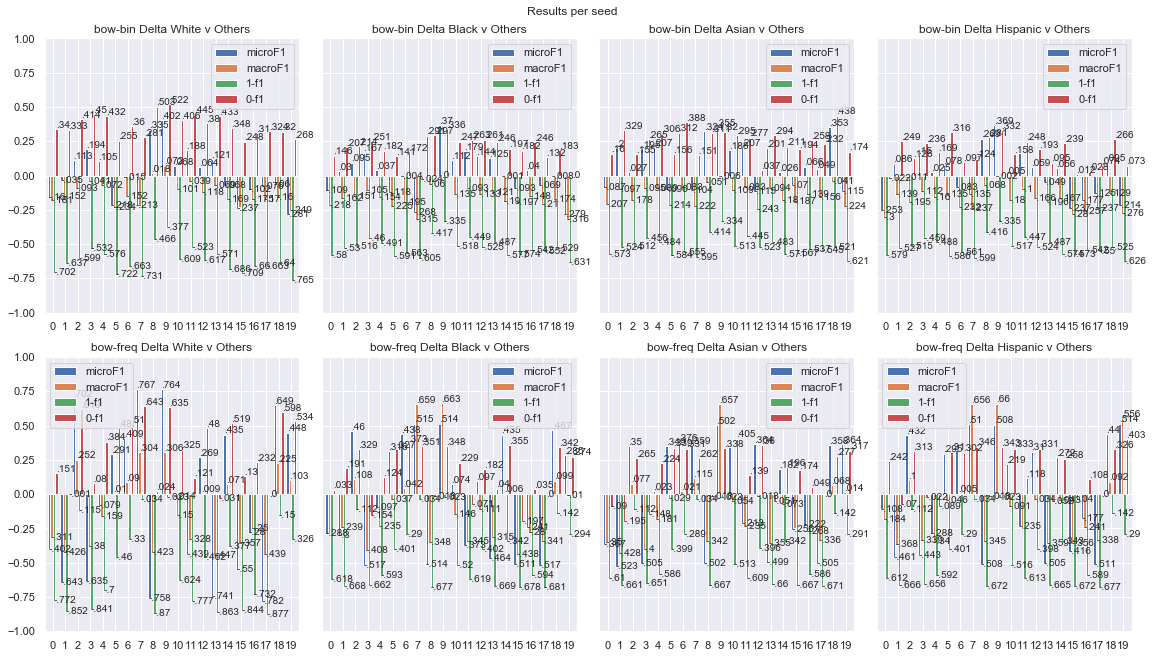

In [52]:
fig, ax = plt.subplots(2,4, sharey=True, figsize=(16,9))
LIM = 1

plots.plot_df(df=df_bb_delta_W,ax=ax[0][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bb_delta_N,ax=ax[0][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bb_delta_A,ax=ax[0][2],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bb_delta_H,ax=ax[0][3],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)

plots.plot_df(df=df_bf_delta_W,ax=ax[1][0],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bf_delta_N,ax=ax[1][1],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bf_delta_A,ax=ax[1][2],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)
plots.plot_df(df=df_bf_delta_H,ax=ax[1][3],x="seed",ys=["microF1","macroF1","1-f1","0-f1"], annotation_size=10, max_y=LIM, min_y=-LIM)

ax[0][0].set_title("bow-bin Delta White v Others")
ax[0][1].set_title("bow-bin Delta Black v Others")
ax[0][2].set_title("bow-bin Delta Asian v Others")
ax[0][3].set_title("bow-bin Delta Hispanic v Others")

ax[1][0].set_title("bow-freq Delta White v Others")
ax[1][1].set_title("bow-freq Delta Black v Others")
ax[1][2].set_title("bow-freq Delta Asian v Others")
ax[1][3].set_title("bow-freq Delta Hispanic v Others")

ax[0][0].legend(loc='best')
ax[0][1].legend(loc='best')
ax[0][2].legend(loc='best')
ax[0][3].legend(loc='best')
ax[1][0].legend(loc='best')
ax[1][1].legend(loc='best')
ax[1][2].legend(loc='best')
ax[1][3].legend(loc='best')

plt.tight_layout()
fig.suptitle("Results per seed",y=1.01)

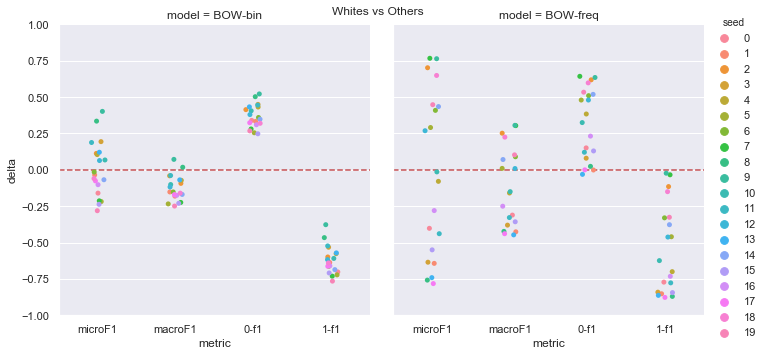

In [53]:
df_delta_long_W = df_bb_delta_long_W.append(df_bf_delta_long_W)
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_W, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-LIM,LIM])
ax2.set_ylim([-LIM,LIM])
plt.suptitle("Whites vs Others")
g

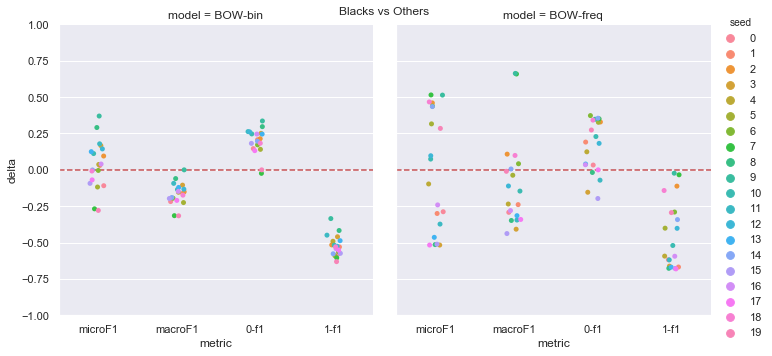

In [54]:
df_delta_long_N = df_bb_delta_long_N.append(df_bf_delta_long_N)
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_N, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-LIM,LIM])
ax2.set_ylim([-LIM,LIM])
plt.suptitle("Blacks vs Others")
g

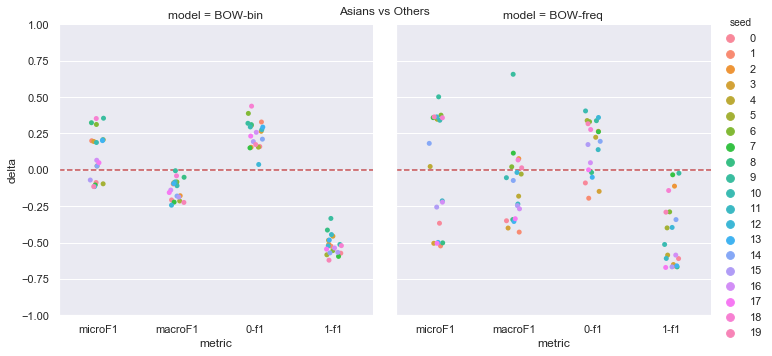

In [55]:
df_delta_long_A = df_bb_delta_long_A.append(df_bf_delta_long_A)
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_A, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-LIM,LIM])
ax2.set_ylim([-LIM,LIM])
plt.suptitle("Asians vs Others")
g

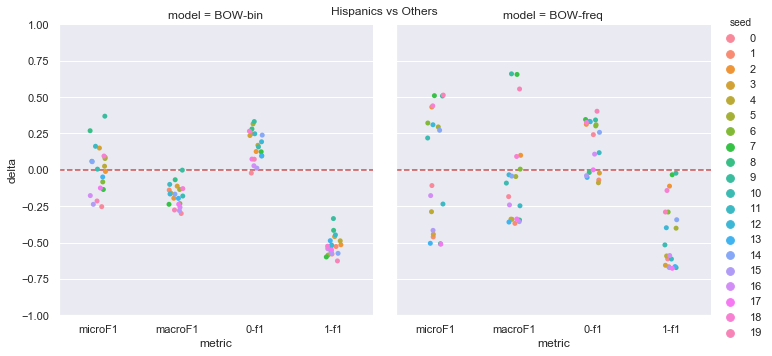

In [56]:
df_delta_long_H = df_bb_delta_long_H.append(df_bf_delta_long_H)
g = sns.catplot(x="metric", y="delta", hue="seed", data=df_delta_long_H, col="model")
ax1, ax2 = g.axes[0]
ax1.axhline(0, ls='--',c="r")
ax2.axhline(0, ls='--',c="r")
ax1.set_ylim([-LIM,LIM])
ax2.set_ylim([-LIM,LIM])
plt.suptitle("Hispanics vs Others")
g